* load lightning module from checkpoints
* eval models with various decision score on metrics
* visualisation sample

In [1]:
import hydra
from src.commons.constants import PROJECT_PATH
from omegaconf import DictConfig, OmegaConf

import numpy as np
import cv2
from PIL import Image
import torch
import pytorch_lightning as pl
import pandas as pd
import os
from copy import deepcopy
import torch.nn.functional as F
from torchmetrics import Metric
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from torch.utils import data
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

from src.commons.utils_io import load_sam, make_path, check_dir
from src.commons.utils import *
from src.models.commons.mask_process import extract_object_from_batch, binarize_mask
from src.commons.constants import *
from src.data.process import generate_grid_prompt
from src.models.magic_pen.task import MagicPenModule

### Load config from run

Inside a Lightning checkpoint you’ll find:

* 16-bit scaling factor (if using 16-bit precision training)
* Current epoch
* Global step
* LightningModule’s state_dict
* State of all optimizers
* State of all learning rate schedulers
* State of all callbacks (for stateful callbacks)
* State of datamodule (for stateful datamodules)
* The hyperparameters (init arguments) with which the model was created
* The hyperparameters (init arguments) with which the datamodule was created 
* State of Loops

In [2]:
_SHARE_PATH = "levir-cd/vit-b"

def _cfg_meta(exp_name, id_exp, folder_root=None, description=""):
    """generate register items - to be updated"""
    if folder_root is None: folder_root = ""
    cfg = {
        "path": make_path(
                    id_exp, 
                    LOGS_PATH, 
                    "final_logs",
                    folder_root,
                    exp_name,
                    _SHARE_PATH
                ),
        "description": description
    }

    if not os.path.exists(cfg["path"]): 
        raise FileNotFoundError(f"Exp run logs not found :{cfg['path']}")
    return cfg

# TODO: integrate in src/
_register_runs = {
    # PROBING
    "probing_concat_baseline": 
        _cfg_meta("train_probing_concat", "2024-08-07_17-50-07", folder_root="08082024_train_first_modules", description=""),
    "probing_diff_baseline":
        _cfg_meta("train_probing_diff", "2024-08-07_17-50-30", folder_root="08082024_train_first_modules", description=""),
    "probing_attn_baseline":
        _cfg_meta("train_probing_attn", "2024-08-07_17-51-53", folder_root="08082024_train_first_modules", description=""),
    
    # ADAPTER
    "adapter_diff_bce_lr10-4":
        _cfg_meta("train_adapter_diff", "2024-08-07_17-52-31", folder_root="08082024_train_first_modules", description=""),
    "adapter_concat_bce_lr10-4":
        _cfg_meta("train_adapter_concat", "2024-08-07_17-53-32", folder_root="08082024_train_first_modules", description=""),
    "adapter_attn_bce_lr10-4":
        _cfg_meta("train_adapter_attn", "2024-08-07_18-15-08", folder_root="08082024_train_first_modules", description=""),
    
    # LORA
    "lora_diff_bce_lr10-4":
        _cfg_meta("train_lora_diff", "2024-08-07_18-22-22", folder_root="08082024_train_first_modules", description=""),
    "lora_concat_bce_lr10-4":
        _cfg_meta("train_lora_concat", "2024-08-07_18-21-49", folder_root="08082024_train_first_modules", description=""),
    "lora_attn_bce_lr10-4":
        _cfg_meta("train_lora_attn", "2024-08-07_18-22-20", folder_root="08082024_train_first_modules", description=""),
    "lora_attnconc_focal_dice_lr5x10-4":
        _cfg_meta("lora_attnconc_focal_dice_lr5x10-4", "1448002", folder_root="", description=""),
    "lora_concat_k32_bce_lr5x10-3":
        _cfg_meta("lora_concat_2node4GPU_k32_bce_lr10-3", "1301549", folder_root="", description=""),
    
    # EXPLO lr ADAPTER
    "adapter_concat_bce_lrx10-4_shuffle":
        _cfg_meta("adapter_train_lr10-4_shuffle", "1500525", folder_root="", description=""),
    "adapter_concat_bce_lr3x10-4_shuffle":
        _cfg_meta("adapter_train_lr3x10-4_shuffle", "1486468", folder_root="", description=""),
    "adapter_attnconc_bce_lr3x10-4":
        _cfg_meta("adapter_attnconc_bce_lr3x10-4", "1387852", folder_root="", description=""),
    "adapter_attnconc_bce_lr10-4":
        _cfg_meta("adapter_attnconc_bce_lr10-4", "1380222", folder_root="", description=""),
    "adapter_attnconc_bce_lr5x10-4":
        _cfg_meta("adapter_attnconc_bce_lr5x10-4", "1447907", folder_root="", description=""),
    "adapter_attnconc_focal_dice_lr5x10-4":
        _cfg_meta("adapter_attnconc_focal_dice_lr5x10-4", "1447968", folder_root="", description=""),


    # last exp
    "last_exp_0209_probing_attn_bce_lr10-4":
        _cfg_meta("last_exp_0209_probing_attn_bce_lr10-4", "1580310", folder_root="", description=""),
    "last_exp_0209_lora_concat_k32_lr3x10-4":
        _cfg_meta("last_exp_0209_lora_concat_k32_lr3x10-4", "1579810", folder_root="", description=""),
    "last_exp_0209_lora_attn_bce_lr10-4":
        _cfg_meta("last_exp_0209_lora_attn_bce_lr10-4", "1580312", folder_root="", description=""),
    "last_exp_0209_adapter_concat_focal_lr10-4":
        _cfg_meta("last_exp_0209_adapter_concat_focal_lr10-4", "1579560", folder_root="", description=""),
    "last_exp_0209_adapter_concat_focal_dice_lr10-4":
        _cfg_meta("last_exp_0209_adapter_concat_focal_dice_lr10-4", "1579591", folder_root="", description=""),
    "last_exp_0209_adapter_attn_focal_dice_lr3x10-4":
        _cfg_meta("last_exp_0209_adapter_attn_focal_dice_lr3x10-4", "1580091", folder_root="", description=""),
    "last_exp_0209_adapter_concat_bce_lr5x10-4":
    _cfg_meta("last_exp_0209_adapter_concat_bce_lr5x10-4", "1579415", folder_root="", description=""),

}

def find_best_ckpt(run_path):
    run_path = os.path.join(run_path, "checkpoints")
    fname = [_ for _ in os.listdir(run_path) if _.startswith("epoch_")]
    if fname:
        fname=fname[0]
    else:
        raise ValueError("ckpt not found")
    return make_path(fname, run_path)

def check_exp(exp_name):
    if exp_name not in _register_runs:
        raise ValueError(f"Exp name {exp_name} not found")

def _cfg_path(exp_name):
    check_exp(exp_name)
    return make_path(
        ".hydra/config.yaml",
        _register_runs[exp_name]["path"],
        )

def _ckpt_path(exp_name):
    check_exp(exp_name)
    return find_best_ckpt(_register_runs[exp_name]["path"])

def load_default_loss():
    return nn.BCEWithLogitsLoss()

In [3]:
#model.optimzier.load_state_dict(MyMode.load_optimizer_checkpoint(last_checkpoint))

In [4]:
def load_cfg(exp_name):
    return OmegaConf.load(_cfg_path(exp_name))


def load_params_module(cfg):
    scheduler, optimizer = None, None
    loss = load_default_loss()
    model = hydra.utils.instantiate(cfg.model.instance.network)
    if "optimizer" in cfg.model:
        optimizer = hydra.utils.instantiate(cfg.model.optimizer)
    if "scheduler" in cfg.model:
        scheduler = hydra.utils.instantiate(cfg.model.scheduler)
    if "loss" in cfg.model:
        loss = hydra.utils.instantiate(cfg.model.loss)
        
    return dict(model=model, optimizer=optimizer, scheduler=scheduler, loss=loss, task_name=cfg.task_name)

def load_dmodule(cfg):
    return hydra.utils.instantiate(cfg.data)

def load_lmodule(exp_name, params):
    return MagicPenModule.load_from_checkpoint(
        _ckpt_path(exp_name),
        optimizer=params.get("optimizer"),
        scheduler=params.get("scheduler"),
        loss=params.get("loss"),
        network = params.get("model"),
        task_name=params.get("task_name")
    )

def load_exp(exp_name):
    
    cfg = load_cfg(exp_name)
    params = load_params_module(cfg)
    data_module = load_dmodule(cfg)
    module = load_lmodule(exp_name, params)
    
    return cfg, data_module, module

In [5]:
# exp_name = "probing_concat_baseline"
# cfg, data_module, module = load_exp(exp_name)

#### Restoring Training State
If you don’t just want to load weights, but instead restore the full training, do the following:
```
model = LitModel()
trainer = Trainer(resume_from_checkpoint='some/path/to/my_checkpoint.ckpt')

# automatically restores model, epoch, step, LR schedulers, apex, etc...
trainer.fit(model)
```

### Run inference

In [6]:
def get_dloader(mode: str, dmodule):

    def wrap_mode(mode):
        if mode == "train":
            return "fit"
        return mode
    if not dmodule.ds_dict_type:
        mode_ = wrap_mode(mode)
        dmodule.setup(mode_)
    factory_dl = {
        "train": dmodule.train_dataloader,
        "val": dmodule.val_dataloader,
        "test": dmodule.test_dataloader,
    }
    return factory_dl[mode]()

def get_ds(mode: str, dmodule):
    
    def wrap_mode(mode):
        if mode == "train":
            return "fit"
        return mode
        
    if not dmodule.ds_dict_type:
        mode_ = wrap_mode(mode)
        dmodule.setup(mode_)
        
    return dmodule.ds_dict_type[mode]

In [7]:
# dloader = get_dloader("test", data_module)
# ds = get_ds("test", data_module)

In [8]:
# batch = next(iter(dloader))

In [9]:
# show_sample_from_batch(batch, idx=0)

In [10]:
def infer_on_sample(ds, module, fname=None, fidx=None):
    if not any([fname, fidx]):
        raise ValueError("Please provide at least a sample name or an sample index")
    # priority to fname
    if fname is not None:
        fidx = ds.get_from_name(fname, return_sample=False)
    # TODO: allow indices sequence
    if isinstance(fidx, int): fidx = [fidx]
    sub_dl = data.DataLoader(data.Subset(ds, fidx), batch_size=1, shuffle=False)
    batch = next(iter(sub_dl))

    # workaround  prevent wrong device association buffers in SAM
    # module = module.to("cpu")
    preds, _ = module(batch)
    # B x 1 x 1024 x 1024
    preds = preds.squeeze().detach().cpu()
    label = label.squeeze().detach().cpu()
    return preds, label, batch

In [11]:
def convert_to_device(batch, device="cuda"):
    for name in ['img_A', 'img_B', 'label', 'point_coords', 'point_labels']:
        batch[name] = batch[name].to(device)
    return batch

### Eval on instances

In [12]:
from torchmetrics import MetricCollection
from torchmetrics.classification import BinaryF1Score, BinaryJaccardIndex, BinaryRecall, BinaryPrecision, Recall, Precision, JaccardIndex
from pathlib import Path

@torch.no_grad()
def _step(module, batch, device, sgmd):
    
    batch = convert_to_device(batch, device=device)
    preds, _ = module(batch)
    preds = preds.squeeze().detach()
    preds = sgmd(preds)
    label = batch["label"].squeeze().detach()
    return preds, label

def f1_score(precision, recall):
    if not (precision + recall):
        return 0
    return 2 * (precision*recall)/(precision + recall)

def evaluate_exp(exp_name, ds_name, batch_size=1, ds_type="test", save_preds=False, save_scores=True):

    report_dir = check_dir(PROJECT_PATH, "reports", "scores", ds_name, "instances", exp_name)
    
    th_list = np.arange(0., 1, 0.1)
    
    cfg, data_module, module = load_exp(exp_name)
    ds = get_ds(ds_type, data_module)
    dloader = data.DataLoader(ds, batch_size=batch_size, shuffle=False)
    
    module = module.to(device)
    sgmd = nn.Sigmoid()
        
    # micro metrics compute metrics on global counts TP, FP, etc - need to keep track them
    eval_engine_micro = {
        th: MetricCollection(
                Recall(threshold=th, average="micro", task="binary"),
                JaccardIndex(threshold=th, average="micro", task="binary"),
                Precision(threshold=th, average="micro", task="binary")
        ).to(device) for th in th_list
    }
    for i, batch in enumerate(tqdm(dloader)):
        
        preds, label = _step(module, batch, device, sgmd)
    
        if save_preds:
            fname = f"pred_{Path(batch['label_path'].stem)}.pt"
            folder = check_dir(report_dir, f"pred_{ds_type}")
            torch.save(preds, make_path(fname, folder))
        
        for th in th_list:
            eval_engine_micro[th].update(preds, label)
            
    scores_micro = {th: eval_engine_micro[th].compute() for th in th_list}
    df_micro = pd.DataFrame(scores_micro).map(float).T
    df_micro["BinaryF1Score"] = df_micro.apply(lambda x: f1_score(x["BinaryPrecision"], x["BinaryRecall"]), axis=1)
    df_micro.columns = ["".join([_, "_micro"]) for _ in df_micro]
    if save_scores:
        df_micro.to_csv(make_path(f"{exp_name}_scores_micro.csv", report_dir), index=True)
    return df_micro

## Infer

In [54]:
%%time
ds_name = "levir-cd"
device = "cpu"
batch_size = 1
ds_type = "test"
save_preds = False
save_scores=True

fname=None
fidx=100

exp_name = "adapter_concat_bce_lrx10-4_shuffle"

if not any([fname, fidx]):
    raise ValueError("Please provide at least a sample name or an sample index")
# priority to fname
if fname is not None:
    fidx = ds.get_from_name(fname, return_sample=False)
# TODO: allow indices sequence
if isinstance(fidx, int): fidx = [fidx]


cfg, data_module, module = load_exp(exp_name)
ds = get_ds(ds_type, data_module)
sub_dl = data.DataLoader(data.Subset(ds, fidx), batch_size=1, shuffle=False)
batch = next(iter(sub_dl))

module = module.to(device)
sgmd = nn.Sigmoid()

INIT ADAPTER VIT


2024-09-16 13:36:13,340 - INFO ::  Weights loaded for : ['image_encoder']


CPU times: user 2min 1s, sys: 2.69 s, total: 2min 4s
Wall time: 3.28 s


In [56]:
%%time
preds, label = _step(module, batch, device, sgmd)

CPU times: user 2min 29s, sys: 19.1 s, total: 2min 48s
Wall time: 3.52 s


In [44]:
preds.shape

torch.Size([1024, 1024])

In [45]:
from src.commons.utils import *

In [46]:
output = {}
output["batch"] = batch.copy()
output["pred"] = preds.unsqueeze(0)

torch.Size([624, 624])


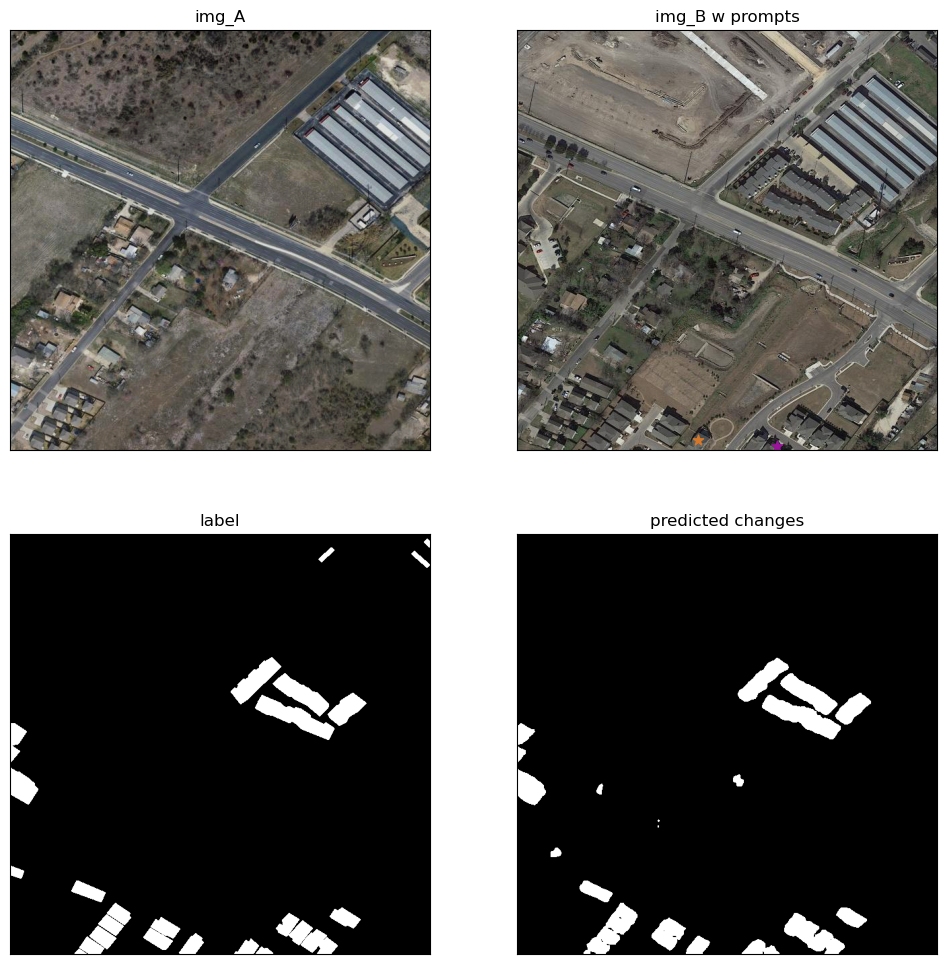

In [47]:
idx=0
masks = output["pred"].cpu()
img_A = output["batch"]["img_A"].cpu()
img_B = output["batch"]["img_B"].cpu()
label = output["batch"]["label"].cpu()

prompts = output["batch"]["point_coords"].cpu()

crop = [400, 400, 300, 300]
if idx is not None:
    masks = masks[idx].squeeze(0)[crop[0]:, crop[1]:]
    img_A = img_A[idx].squeeze(0)[:, crop[0]:, crop[1]:]
    img_B = img_B[idx].squeeze(0)[:, crop[0]:, crop[1]:]
    label = label[idx].squeeze(0)[crop[0]:, crop[1]:]
    prompts = prompts[idx].squeeze(0)            
print(masks.shape)
# shift range for vizu
#masks = shift_range_values(masks)
imgs = [img_A, img_B, label, masks]
names = ["img_A", "img_B w prompts", "label", "predicted changes"]

fig, axs = plt.subplots(nrows=len(imgs)//2, ncols=len(imgs) // 2, squeeze=False, figsize=(12, 12))
axs = axs.ravel()
for i, sample in enumerate(zip(imgs, names)):
    img, name = sample
    if name.startswith("im"):
        img = to_numpy(img, transpose=True) / 255
        axs[i].imshow(img)

    else:
        img = to_numpy(img, transpose=False)
        axs[i].imshow(img > 0.5, cmap="Greys_r")

    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    axs[i].set_title(name)
    if name == "img_B w prompts":
        if prompts.shape[0] < 100:  # prevent showing grid
            # work around crop
            ptss_x = (prompts[:, 0] - crop[1]).numpy()
            ptss_y = (prompts[:, 1] - crop[0]).numpy()
            ptss = list(zip(ptss_y, ptss_x))
            ptss = [pt for pt in ptss if (pt[0] > 0) and (pt[1] > 0)]
            colors = [
                np.random.choice(range(256), size=3) / 255
                for _ in range(len(ptss))
            ]
            for pt, c in zip(ptss, colors):
                axs[i].scatter(*pt[::-1], color=c, marker="*", s=60)

In [48]:
ptss

[(609.0, 268.0), (618.0, 385.0)]

In [80]:
ptss_x = (prompts[:, 0] - 500).numpy()
ptss_y = (prompts[:, 1] - 0).numpy()
ptss = list(zip(ptss_x, ptss_y))
ptss = [pt for pt in ptss if pt[0] > 0 and pt[1] > 0]

In [81]:
ptss

[(486.0, 196.0), (258.0, 261.0)]

In [84]:
prompts[:, 0]

tensor([476., 986., 758.])

### Eval all exps

In [57]:
ds_name = "levir-cd"
device = "cuda"
batch_size = 1
ds_type = "test"
save_preds = False
save_scores=True
n_runs = len(_register_runs)

for i, exp_name in enumerate(_register_runs, start=1):
    print(f"Eval {exp_name} - {i}/{n_runs}")
    df_micro = evaluate_exp(
        exp_name=exp_name, 
        ds_name=ds_name,
        batch_size=batch_size, 
        ds_type=ds_type, 
        save_preds=save_preds,
        save_scores=save_scores
    )

Eval probing_concat_baseline - 1/15
INIT VIT


2024-08-28 20:06:40,114 - INFO ::  Weights loaded for : ['image_encoder']
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [03:57<00:00,  1.86s/it]


Eval probing_diff_baseline - 2/15
INIT VIT


2024-08-28 20:10:38,971 - INFO ::  Weights loaded for : ['image_encoder']
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [04:25<00:00,  2.07s/it]


Eval probing_attn_baseline - 3/15
INIT VIT


2024-08-28 20:15:05,590 - INFO ::  Weights loaded for : ['image_encoder']
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [04:35<00:00,  2.16s/it]


Eval adapter_diff_bce_lr10-4 - 4/15
INIT ADAPTER VIT


2024-08-28 20:19:42,787 - INFO ::  Weights loaded for : ['image_encoder']
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [05:10<00:00,  2.42s/it]


Eval adapter_concat_bce_lr10-4 - 5/15
INIT ADAPTER VIT


2024-08-28 20:24:54,379 - INFO ::  Weights loaded for : ['image_encoder']
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [04:41<00:00,  2.20s/it]


Eval adapter_attn_bce_lr10-4 - 6/15
INIT ADAPTER VIT


2024-08-28 20:29:38,140 - INFO ::  Weights loaded for : ['image_encoder']
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [04:15<00:00,  2.00s/it]


Eval lora_diff_bce_lr10-4 - 7/15
INIT VIT
INIT LORA VIT


2024-08-28 20:33:56,362 - INFO ::  Weights loaded for : ['image_encoder']
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [04:29<00:00,  2.10s/it]


Eval lora_concat_bce_lr10-4 - 8/15
INIT VIT
INIT LORA VIT


2024-08-28 20:38:27,337 - INFO ::  Weights loaded for : ['image_encoder']
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [04:08<00:00,  1.94s/it]


Eval lora_attn_bce_lr10-4 - 9/15
INIT VIT


2024-08-28 20:42:37,581 - INFO ::  Weights loaded for : ['image_encoder']


INIT LORA VIT


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [04:34<00:00,  2.15s/it]


Eval lora_attnconc_focal_dice_lr5x10-4 - 10/15
INIT VIT


2024-08-28 20:47:14,074 - INFO ::  Weights loaded for : ['image_encoder']


INIT LORA VIT


  0%|                                                                                                                                     | 0/128 [00:00<?, ?it/s]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  1%|▉                                                                                                                            | 1/128 [00:02<04:43,  2.23s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  2%|█▉                                                                                                                           | 2/128 [00:04<04:23,  2.09s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  2%|██▉                                                                                                                          | 3/128 [00:06<04:20,  2.08s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  3%|███▉                                                                                                                         | 4/128 [00:08<04:17,  2.07s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  4%|████▉                                                                                                                        | 5/128 [00:10<04:15,  2.08s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  5%|█████▊                                                                                                                       | 6/128 [00:12<04:08,  2.04s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  5%|██████▊                                                                                                                      | 7/128 [00:14<04:16,  2.12s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  6%|███████▊                                                                                                                     | 8/128 [00:16<04:17,  2.14s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  7%|████████▊                                                                                                                    | 9/128 [00:19<04:14,  2.14s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  8%|█████████▋                                                                                                                  | 10/128 [00:21<04:15,  2.16s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  9%|██████████▋                                                                                                                 | 11/128 [00:23<04:04,  2.09s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  9%|███████████▋                                                                                                                | 12/128 [00:25<03:58,  2.05s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 10%|████████████▌                                                                                                               | 13/128 [00:27<03:56,  2.05s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 11%|█████████████▌                                                                                                              | 14/128 [00:29<03:55,  2.07s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 12%|██████████████▌                                                                                                             | 15/128 [00:31<03:47,  2.02s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 12%|███████████████▌                                                                                                            | 16/128 [00:33<03:44,  2.01s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 13%|████████████████▍                                                                                                           | 17/128 [00:35<03:42,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 14%|█████████████████▍                                                                                                          | 18/128 [00:37<03:51,  2.10s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 15%|██████████████████▍                                                                                                         | 19/128 [00:39<03:41,  2.04s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 16%|███████████████████▍                                                                                                        | 20/128 [00:41<03:44,  2.08s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 16%|████████████████████▎                                                                                                       | 21/128 [00:43<03:38,  2.04s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 17%|█████████████████████▎                                                                                                      | 22/128 [00:45<03:31,  1.99s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 18%|██████████████████████▎                                                                                                     | 23/128 [00:47<03:21,  1.92s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 19%|███████████████████████▎                                                                                                    | 24/128 [00:48<03:14,  1.87s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 20%|████████████████████████▏                                                                                                   | 25/128 [00:50<03:11,  1.86s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 20%|█████████████████████████▏                                                                                                  | 26/128 [00:52<03:10,  1.86s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 21%|██████████████████████████▏                                                                                                 | 27/128 [00:54<03:12,  1.90s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 22%|███████████████████████████▏                                                                                                | 28/128 [00:56<03:09,  1.89s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 23%|████████████████████████████                                                                                                | 29/128 [00:58<03:12,  1.95s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 23%|█████████████████████████████                                                                                               | 30/128 [01:00<03:14,  1.98s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 24%|██████████████████████████████                                                                                              | 31/128 [01:02<03:11,  1.98s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 25%|███████████████████████████████                                                                                             | 32/128 [01:04<03:05,  1.93s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 26%|███████████████████████████████▉                                                                                            | 33/128 [01:06<03:01,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 27%|████████████████████████████████▉                                                                                           | 34/128 [01:08<03:04,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 27%|█████████████████████████████████▉                                                                                          | 35/128 [01:10<03:05,  1.99s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 28%|██████████████████████████████████▉                                                                                         | 36/128 [01:12<02:58,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 29%|███████████████████████████████████▊                                                                                        | 37/128 [01:14<03:00,  1.98s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 30%|████████████████████████████████████▊                                                                                       | 38/128 [01:16<03:00,  2.01s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 30%|█████████████████████████████████████▊                                                                                      | 39/128 [01:18<02:59,  2.01s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 31%|██████████████████████████████████████▊                                                                                     | 40/128 [01:20<02:54,  1.98s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 32%|███████████████████████████████████████▋                                                                                    | 41/128 [01:22<02:54,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 33%|████████████████████████████████████████▋                                                                                   | 42/128 [01:24<02:47,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 34%|█████████████████████████████████████████▋                                                                                  | 43/128 [01:25<02:40,  1.89s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 34%|██████████████████████████████████████████▋                                                                                 | 44/128 [01:27<02:38,  1.89s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 35%|███████████████████████████████████████████▌                                                                                | 45/128 [01:30<02:52,  2.07s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 36%|████████████████████████████████████████████▌                                                                               | 46/128 [01:32<02:55,  2.14s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 37%|█████████████████████████████████████████████▌                                                                              | 47/128 [01:34<02:47,  2.07s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 38%|██████████████████████████████████████████████▌                                                                             | 48/128 [01:36<02:39,  1.99s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 38%|███████████████████████████████████████████████▍                                                                            | 49/128 [01:38<02:36,  1.98s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 39%|████████████████████████████████████████████████▍                                                                           | 50/128 [01:40<02:32,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 40%|█████████████████████████████████████████████████▍                                                                          | 51/128 [01:42<02:29,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 41%|██████████████████████████████████████████████████▍                                                                         | 52/128 [01:44<02:28,  1.95s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 41%|███████████████████████████████████████████████████▎                                                                        | 53/128 [01:45<02:25,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 42%|████████████████████████████████████████████████████▎                                                                       | 54/128 [01:47<02:21,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 43%|█████████████████████████████████████████████████████▎                                                                      | 55/128 [01:49<02:23,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 44%|██████████████████████████████████████████████████████▎                                                                     | 56/128 [01:51<02:16,  1.90s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 45%|███████████████████████████████████████████████████████▏                                                                    | 57/128 [01:53<02:12,  1.87s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 45%|████████████████████████████████████████████████████████▏                                                                   | 58/128 [01:55<02:07,  1.82s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 46%|█████████████████████████████████████████████████████████▏                                                                  | 59/128 [01:56<02:03,  1.79s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 47%|██████████████████████████████████████████████████████████▏                                                                 | 60/128 [01:58<01:59,  1.76s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 48%|███████████████████████████████████████████████████████████                                                                 | 61/128 [02:00<01:55,  1.73s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 48%|████████████████████████████████████████████████████████████                                                                | 62/128 [02:01<01:52,  1.71s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 49%|█████████████████████████████████████████████████████████████                                                               | 63/128 [02:03<01:50,  1.71s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 50%|██████████████████████████████████████████████████████████████                                                              | 64/128 [02:05<01:50,  1.72s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 51%|██████████████████████████████████████████████████████████████▉                                                             | 65/128 [02:07<01:48,  1.73s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 52%|███████████████████████████████████████████████████████████████▉                                                            | 66/128 [02:08<01:47,  1.73s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 52%|████████████████████████████████████████████████████████████████▉                                                           | 67/128 [02:10<01:49,  1.79s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 53%|█████████████████████████████████████████████████████████████████▉                                                          | 68/128 [02:12<01:51,  1.85s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 54%|██████████████████████████████████████████████████████████████████▊                                                         | 69/128 [02:15<01:56,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 55%|███████████████████████████████████████████████████████████████████▊                                                        | 70/128 [02:17<02:00,  2.08s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 55%|████████████████████████████████████████████████████████████████████▊                                                       | 71/128 [02:19<01:55,  2.02s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 56%|█████████████████████████████████████████████████████████████████████▊                                                      | 72/128 [02:21<01:54,  2.04s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 57%|██████████████████████████████████████████████████████████████████████▋                                                     | 73/128 [02:23<01:47,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 58%|███████████████████████████████████████████████████████████████████████▋                                                    | 74/128 [02:25<01:46,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 59%|████████████████████████████████████████████████████████████████████████▋                                                   | 75/128 [02:27<01:44,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 59%|█████████████████████████████████████████████████████████████████████████▋                                                  | 76/128 [02:28<01:39,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 60%|██████████████████████████████████████████████████████████████████████████▌                                                 | 77/128 [02:30<01:35,  1.88s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 61%|███████████████████████████████████████████████████████████████████████████▌                                                | 78/128 [02:32<01:34,  1.89s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 62%|████████████████████████████████████████████████████████████████████████████▌                                               | 79/128 [02:34<01:32,  1.88s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 62%|█████████████████████████████████████████████████████████████████████████████▌                                              | 80/128 [02:36<01:33,  1.95s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 63%|██████████████████████████████████████████████████████████████████████████████▍                                             | 81/128 [02:38<01:30,  1.93s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 64%|███████████████████████████████████████████████████████████████████████████████▍                                            | 82/128 [02:40<01:25,  1.86s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 65%|████████████████████████████████████████████████████████████████████████████████▍                                           | 83/128 [02:42<01:25,  1.90s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 66%|█████████████████████████████████████████████████████████████████████████████████▍                                          | 84/128 [02:44<01:24,  1.93s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 66%|██████████████████████████████████████████████████████████████████████████████████▎                                         | 85/128 [02:46<01:23,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 67%|███████████████████████████████████████████████████████████████████████████████████▎                                        | 86/128 [02:47<01:18,  1.88s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 68%|████████████████████████████████████████████████████████████████████████████████████▎                                       | 87/128 [02:49<01:18,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 69%|█████████████████████████████████████████████████████████████████████████████████████▎                                      | 88/128 [02:51<01:13,  1.84s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 70%|██████████████████████████████████████████████████████████████████████████████████████▏                                     | 89/128 [02:53<01:10,  1.82s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                    | 90/128 [02:54<01:08,  1.81s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                   | 91/128 [02:56<01:08,  1.86s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                  | 92/128 [02:58<01:08,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 73%|██████████████████████████████████████████████████████████████████████████████████████████                                  | 93/128 [03:00<01:04,  1.84s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 73%|███████████████████████████████████████████████████████████████████████████████████████████                                 | 94/128 [03:02<01:00,  1.78s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 74%|████████████████████████████████████████████████████████████████████████████████████████████                                | 95/128 [03:04<00:58,  1.76s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 75%|█████████████████████████████████████████████████████████████████████████████████████████████                               | 96/128 [03:05<00:55,  1.74s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 76%|█████████████████████████████████████████████████████████████████████████████████████████████▉                              | 97/128 [03:07<00:54,  1.75s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 77%|██████████████████████████████████████████████████████████████████████████████████████████████▉                             | 98/128 [03:09<00:51,  1.72s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                            | 99/128 [03:10<00:49,  1.72s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 78%|████████████████████████████████████████████████████████████████████████████████████████████████                           | 100/128 [03:12<00:51,  1.83s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████                          | 101/128 [03:14<00:49,  1.84s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████                         | 102/128 [03:16<00:46,  1.81s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 103/128 [03:18<00:46,  1.86s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 104/128 [03:20<00:43,  1.83s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 105/128 [03:22<00:43,  1.88s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 106/128 [03:24<00:40,  1.84s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 107/128 [03:25<00:37,  1.80s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 108/128 [03:27<00:35,  1.76s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 109/128 [03:29<00:33,  1.76s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 110/128 [03:31<00:32,  1.80s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 111/128 [03:32<00:30,  1.80s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 112/128 [03:34<00:28,  1.78s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 113/128 [03:36<00:27,  1.80s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 114/128 [03:38<00:25,  1.80s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 115/128 [03:40<00:24,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 116/128 [03:42<00:22,  1.87s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 117/128 [03:43<00:20,  1.84s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 118/128 [03:46<00:19,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 119/128 [03:48<00:17,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 120/128 [03:50<00:16,  2.02s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 121/128 [03:52<00:13,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 122/128 [03:53<00:11,  1.86s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 123/128 [03:55<00:09,  1.84s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 124/128 [03:57<00:07,  1.81s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 125/128 [03:58<00:05,  1.76s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 126/128 [04:00<00:03,  1.83s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 127/128 [04:02<00:01,  1.84s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [04:04<00:00,  1.91s/it]


Eval lora_concat_k32_bce_lr5x10-3 - 11/15
INIT VIT


2024-08-28 20:51:19,995 - INFO ::  Weights loaded for : ['image_encoder']


INIT LORA VIT


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [04:02<00:00,  1.90s/it]


Eval adapter_attnconc_bce_lr3x10-4 - 12/15
INIT ADAPTER VIT


2024-08-28 20:55:24,020 - INFO ::  Weights loaded for : ['image_encoder']
  0%|                                                                                                                                     | 0/128 [00:00<?, ?it/s]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  1%|▉                                                                                                                            | 1/128 [00:02<04:19,  2.04s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  2%|█▉                                                                                                                           | 2/128 [00:03<04:04,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  2%|██▉                                                                                                                          | 3/128 [00:05<03:56,  1.89s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  3%|███▉                                                                                                                         | 4/128 [00:07<03:55,  1.90s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  4%|████▉                                                                                                                        | 5/128 [00:09<03:53,  1.90s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  5%|█████▊                                                                                                                       | 6/128 [00:11<03:55,  1.93s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  5%|██████▊                                                                                                                      | 7/128 [00:13<03:57,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  6%|███████▊                                                                                                                     | 8/128 [00:15<03:52,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  7%|████████▊                                                                                                                    | 9/128 [00:17<03:47,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  8%|█████████▋                                                                                                                  | 10/128 [00:19<03:51,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  9%|██████████▋                                                                                                                 | 11/128 [00:21<03:53,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  9%|███████████▋                                                                                                                | 12/128 [00:23<03:51,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 10%|████████████▌                                                                                                               | 13/128 [00:25<03:49,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 11%|█████████████▌                                                                                                              | 14/128 [00:27<03:51,  2.03s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 12%|██████████████▌                                                                                                             | 15/128 [00:29<03:45,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 12%|███████████████▌                                                                                                            | 16/128 [00:31<03:35,  1.93s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 13%|████████████████▍                                                                                                           | 17/128 [00:33<03:33,  1.93s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 14%|█████████████████▍                                                                                                          | 18/128 [00:35<03:33,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 15%|██████████████████▍                                                                                                         | 19/128 [00:37<03:29,  1.93s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 16%|███████████████████▍                                                                                                        | 20/128 [00:39<03:37,  2.02s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 16%|████████████████████▎                                                                                                       | 21/128 [00:41<03:34,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 17%|█████████████████████▎                                                                                                      | 22/128 [00:43<03:28,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 18%|██████████████████████▎                                                                                                     | 23/128 [00:44<03:21,  1.92s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 19%|███████████████████████▎                                                                                                    | 24/128 [00:46<03:14,  1.87s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 20%|████████████████████████▏                                                                                                   | 25/128 [00:48<03:09,  1.84s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 20%|█████████████████████████▏                                                                                                  | 26/128 [00:50<03:08,  1.85s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 21%|██████████████████████████▏                                                                                                 | 27/128 [00:52<03:12,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 22%|███████████████████████████▏                                                                                                | 28/128 [00:54<03:11,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 23%|████████████████████████████                                                                                                | 29/128 [00:56<03:17,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 23%|█████████████████████████████                                                                                               | 30/128 [00:58<03:12,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 24%|██████████████████████████████                                                                                              | 31/128 [01:00<03:08,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 25%|███████████████████████████████                                                                                             | 32/128 [01:02<03:05,  1.93s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 26%|███████████████████████████████▉                                                                                            | 33/128 [01:04<03:03,  1.93s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 27%|████████████████████████████████▉                                                                                           | 34/128 [01:06<03:13,  2.05s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 27%|█████████████████████████████████▉                                                                                          | 35/128 [01:08<03:12,  2.07s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 28%|██████████████████████████████████▉                                                                                         | 36/128 [01:10<03:04,  2.01s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 29%|███████████████████████████████████▊                                                                                        | 37/128 [01:12<03:05,  2.04s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 30%|████████████████████████████████████▊                                                                                       | 38/128 [01:14<03:10,  2.11s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 30%|█████████████████████████████████████▊                                                                                      | 39/128 [01:17<03:13,  2.18s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 31%|██████████████████████████████████████▊                                                                                     | 40/128 [01:19<03:12,  2.19s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 32%|███████████████████████████████████████▋                                                                                    | 41/128 [01:21<03:14,  2.24s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 33%|████████████████████████████████████████▋                                                                                   | 42/128 [01:23<03:04,  2.14s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 34%|█████████████████████████████████████████▋                                                                                  | 43/128 [01:25<02:52,  2.03s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 35%|███████████████████████████████████████████▌                                                                                | 45/128 [01:29<02:58,  2.14s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])
fusion embeddings :  torch.Size([1, 256, 64, 64])


 36%|████████████████████████████████████████████▌                                                                               | 46/128 [01:32<02:57,  2.17s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 37%|█████████████████████████████████████████████▌                                                                              | 47/128 [01:34<02:52,  2.14s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 38%|██████████████████████████████████████████████▌                                                                             | 48/128 [01:35<02:43,  2.04s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 38%|███████████████████████████████████████████████▍                                                                            | 49/128 [01:37<02:41,  2.05s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 39%|████████████████████████████████████████████████▍                                                                           | 50/128 [01:39<02:38,  2.04s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 40%|█████████████████████████████████████████████████▍                                                                          | 51/128 [01:41<02:34,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 41%|██████████████████████████████████████████████████▍                                                                         | 52/128 [01:43<02:32,  2.01s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 41%|███████████████████████████████████████████████████▎                                                                        | 53/128 [01:45<02:29,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 42%|████████████████████████████████████████████████████▎                                                                       | 54/128 [01:47<02:25,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 43%|█████████████████████████████████████████████████████▎                                                                      | 55/128 [01:49<02:27,  2.02s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 44%|██████████████████████████████████████████████████████▎                                                                     | 56/128 [01:51<02:18,  1.92s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 45%|███████████████████████████████████████████████████████▏                                                                    | 57/128 [01:53<02:13,  1.88s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 45%|████████████████████████████████████████████████████████▏                                                                   | 58/128 [01:55<02:09,  1.85s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 46%|█████████████████████████████████████████████████████████▏                                                                  | 59/128 [01:57<02:07,  1.84s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 47%|██████████████████████████████████████████████████████████▏                                                                 | 60/128 [01:58<02:04,  1.83s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 48%|███████████████████████████████████████████████████████████                                                                 | 61/128 [02:00<02:00,  1.80s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 48%|████████████████████████████████████████████████████████████                                                                | 62/128 [02:02<01:56,  1.77s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 49%|█████████████████████████████████████████████████████████████                                                               | 63/128 [02:03<01:53,  1.75s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 50%|██████████████████████████████████████████████████████████████                                                              | 64/128 [02:05<01:52,  1.76s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 51%|██████████████████████████████████████████████████████████████▉                                                             | 65/128 [02:07<01:52,  1.79s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 52%|███████████████████████████████████████████████████████████████▉                                                            | 66/128 [02:09<01:51,  1.79s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 52%|████████████████████████████████████████████████████████████████▉                                                           | 67/128 [02:11<01:54,  1.88s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 53%|█████████████████████████████████████████████████████████████████▉                                                          | 68/128 [02:13<01:55,  1.92s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 54%|██████████████████████████████████████████████████████████████████▊                                                         | 69/128 [02:15<02:00,  2.03s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 55%|███████████████████████████████████████████████████████████████████▊                                                        | 70/128 [02:18<02:02,  2.12s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 55%|████████████████████████████████████████████████████████████████████▊                                                       | 71/128 [02:20<02:01,  2.14s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 56%|█████████████████████████████████████████████████████████████████████▊                                                      | 72/128 [02:22<02:05,  2.23s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 57%|██████████████████████████████████████████████████████████████████████▋                                                     | 73/128 [02:24<01:58,  2.15s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 58%|███████████████████████████████████████████████████████████████████████▋                                                    | 74/128 [02:26<01:55,  2.13s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 59%|████████████████████████████████████████████████████████████████████████▋                                                   | 75/128 [02:28<01:50,  2.08s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 59%|█████████████████████████████████████████████████████████████████████████▋                                                  | 76/128 [02:30<01:43,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 60%|██████████████████████████████████████████████████████████████████████████▌                                                 | 77/128 [02:32<01:42,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 61%|███████████████████████████████████████████████████████████████████████████▌                                                | 78/128 [02:34<01:39,  1.99s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 62%|████████████████████████████████████████████████████████████████████████████▌                                               | 79/128 [02:36<01:36,  1.98s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 62%|█████████████████████████████████████████████████████████████████████████████▌                                              | 80/128 [02:38<01:36,  2.02s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 63%|██████████████████████████████████████████████████████████████████████████████▍                                             | 81/128 [02:40<01:32,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 64%|███████████████████████████████████████████████████████████████████████████████▍                                            | 82/128 [02:42<01:27,  1.90s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 65%|████████████████████████████████████████████████████████████████████████████████▍                                           | 83/128 [02:44<01:26,  1.93s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 66%|█████████████████████████████████████████████████████████████████████████████████▍                                          | 84/128 [02:46<01:26,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 66%|██████████████████████████████████████████████████████████████████████████████████▎                                         | 85/128 [02:48<01:26,  2.02s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 67%|███████████████████████████████████████████████████████████████████████████████████▎                                        | 86/128 [02:50<01:21,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 68%|████████████████████████████████████████████████████████████████████████████████████▎                                       | 87/128 [02:52<01:20,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 69%|█████████████████████████████████████████████████████████████████████████████████████▎                                      | 88/128 [02:53<01:15,  1.89s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 70%|██████████████████████████████████████████████████████████████████████████████████████▏                                     | 89/128 [02:55<01:11,  1.83s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                    | 90/128 [02:57<01:09,  1.82s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                   | 91/128 [02:59<01:09,  1.87s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                  | 92/128 [03:01<01:10,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 73%|██████████████████████████████████████████████████████████████████████████████████████████                                  | 93/128 [03:03<01:07,  1.92s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 73%|███████████████████████████████████████████████████████████████████████████████████████████                                 | 94/128 [03:05<01:03,  1.86s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 74%|████████████████████████████████████████████████████████████████████████████████████████████                                | 95/128 [03:06<01:02,  1.88s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 75%|█████████████████████████████████████████████████████████████████████████████████████████████                               | 96/128 [03:08<00:58,  1.83s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 76%|█████████████████████████████████████████████████████████████████████████████████████████████▉                              | 97/128 [03:10<00:56,  1.81s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 77%|██████████████████████████████████████████████████████████████████████████████████████████████▉                             | 98/128 [03:12<00:54,  1.80s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                            | 99/128 [03:14<00:52,  1.82s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 78%|████████████████████████████████████████████████████████████████████████████████████████████████                           | 100/128 [03:16<00:53,  1.92s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████                          | 101/128 [03:18<00:51,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████                         | 102/128 [03:20<00:50,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 103/128 [03:22<00:51,  2.04s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 104/128 [03:24<00:48,  2.04s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 105/128 [03:26<00:46,  2.03s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 106/128 [03:28<00:43,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 107/128 [03:30<00:39,  1.89s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 108/128 [03:31<00:36,  1.83s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 109/128 [03:33<00:34,  1.80s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 110/128 [03:35<00:34,  1.90s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 111/128 [03:37<00:33,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 112/128 [03:39<00:31,  1.99s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 113/128 [03:41<00:29,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 114/128 [03:43<00:27,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 115/128 [03:46<00:27,  2.09s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 116/128 [03:47<00:24,  2.03s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 117/128 [03:49<00:22,  2.02s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 118/128 [03:52<00:21,  2.15s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 119/128 [03:54<00:19,  2.17s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 120/128 [03:56<00:17,  2.16s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 121/128 [03:58<00:14,  2.08s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 122/128 [04:00<00:11,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 123/128 [04:02<00:09,  1.93s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 124/128 [04:04<00:07,  1.92s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 125/128 [04:05<00:05,  1.88s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 126/128 [04:07<00:03,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 127/128 [04:09<00:01,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [04:11<00:00,  1.96s/it]


Eval adapter_attnconc_bce_lr10-4 - 13/15
INIT ADAPTER VIT


2024-08-28 20:59:36,799 - INFO ::  Weights loaded for : ['image_encoder']
  0%|                                                                                                                                     | 0/128 [00:00<?, ?it/s]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  1%|▉                                                                                                                            | 1/128 [00:01<04:10,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  2%|█▉                                                                                                                           | 2/128 [00:03<04:01,  1.92s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  2%|██▉                                                                                                                          | 3/128 [00:05<03:58,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  3%|███▉                                                                                                                         | 4/128 [00:07<03:58,  1.92s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  4%|████▉                                                                                                                        | 5/128 [00:09<03:58,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  5%|█████▊                                                                                                                       | 6/128 [00:11<03:50,  1.89s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  5%|██████▊                                                                                                                      | 7/128 [00:13<03:59,  1.98s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  6%|███████▊                                                                                                                     | 8/128 [00:15<03:56,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  7%|████████▊                                                                                                                    | 9/128 [00:17<03:52,  1.95s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  8%|█████████▋                                                                                                                  | 10/128 [00:19<03:58,  2.02s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  9%|██████████▋                                                                                                                 | 11/128 [00:21<03:54,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  9%|███████████▋                                                                                                                | 12/128 [00:23<03:53,  2.01s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 10%|████████████▌                                                                                                               | 13/128 [00:25<03:50,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 11%|█████████████▌                                                                                                              | 14/128 [00:27<03:52,  2.04s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 12%|██████████████▌                                                                                                             | 15/128 [00:29<03:56,  2.09s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 12%|███████████████▌                                                                                                            | 16/128 [00:32<03:54,  2.09s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 13%|████████████████▍                                                                                                           | 17/128 [00:33<03:43,  2.01s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 14%|█████████████████▍                                                                                                          | 18/128 [00:36<03:45,  2.05s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 15%|██████████████████▍                                                                                                         | 19/128 [00:37<03:40,  2.02s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 16%|███████████████████▍                                                                                                        | 20/128 [00:40<03:44,  2.08s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 16%|████████████████████▎                                                                                                       | 21/128 [00:42<03:38,  2.04s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 17%|█████████████████████▎                                                                                                      | 22/128 [00:44<03:34,  2.02s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 18%|██████████████████████▎                                                                                                     | 23/128 [00:45<03:25,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 19%|███████████████████████▎                                                                                                    | 24/128 [00:47<03:21,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 20%|████████████████████████▏                                                                                                   | 25/128 [00:49<03:12,  1.87s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 20%|█████████████████████████▏                                                                                                  | 26/128 [00:51<03:12,  1.89s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 21%|██████████████████████████▏                                                                                                 | 27/128 [00:53<03:16,  1.95s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 22%|███████████████████████████▏                                                                                                | 28/128 [00:55<03:17,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 23%|████████████████████████████                                                                                                | 29/128 [00:57<03:21,  2.04s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 23%|█████████████████████████████                                                                                               | 30/128 [00:59<03:15,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 24%|██████████████████████████████                                                                                              | 31/128 [01:01<03:14,  2.01s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 25%|███████████████████████████████                                                                                             | 32/128 [01:03<03:05,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 26%|███████████████████████████████▉                                                                                            | 33/128 [01:05<03:04,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 27%|████████████████████████████████▉                                                                                           | 34/128 [01:07<03:07,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 27%|█████████████████████████████████▉                                                                                          | 35/128 [01:09<03:11,  2.06s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 28%|██████████████████████████████████▉                                                                                         | 36/128 [01:11<03:03,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 29%|███████████████████████████████████▊                                                                                        | 37/128 [01:13<03:08,  2.07s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 30%|████████████████████████████████████▊                                                                                       | 38/128 [01:16<03:08,  2.09s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 30%|█████████████████████████████████████▊                                                                                      | 39/128 [01:18<03:05,  2.08s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 31%|██████████████████████████████████████▊                                                                                     | 40/128 [01:20<03:00,  2.05s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 32%|███████████████████████████████████████▋                                                                                    | 41/128 [01:22<03:00,  2.07s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 33%|████████████████████████████████████████▋                                                                                   | 42/128 [01:24<02:54,  2.02s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 34%|█████████████████████████████████████████▋                                                                                  | 43/128 [01:25<02:46,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 35%|███████████████████████████████████████████▌                                                                                | 45/128 [01:30<03:08,  2.27s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])
fusion embeddings :  torch.Size([1, 256, 64, 64])


 36%|████████████████████████████████████████████▌                                                                               | 46/128 [01:33<03:10,  2.32s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 37%|█████████████████████████████████████████████▌                                                                              | 47/128 [01:35<03:05,  2.29s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 38%|██████████████████████████████████████████████▌                                                                             | 48/128 [01:37<02:54,  2.19s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 38%|███████████████████████████████████████████████▍                                                                            | 49/128 [01:39<02:48,  2.13s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 39%|████████████████████████████████████████████████▍                                                                           | 50/128 [01:41<02:43,  2.10s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 40%|█████████████████████████████████████████████████▍                                                                          | 51/128 [01:43<02:38,  2.06s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 41%|██████████████████████████████████████████████████▍                                                                         | 52/128 [01:45<02:34,  2.04s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 41%|███████████████████████████████████████████████████▎                                                                        | 53/128 [01:47<02:31,  2.02s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 42%|████████████████████████████████████████████████████▎                                                                       | 54/128 [01:49<02:27,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 43%|█████████████████████████████████████████████████████▎                                                                      | 55/128 [01:51<02:28,  2.03s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 44%|██████████████████████████████████████████████████████▎                                                                     | 56/128 [01:53<02:25,  2.02s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 45%|███████████████████████████████████████████████████████▏                                                                    | 57/128 [01:55<02:17,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 45%|████████████████████████████████████████████████████████▏                                                                   | 58/128 [01:56<02:11,  1.88s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 46%|█████████████████████████████████████████████████████████▏                                                                  | 59/128 [01:58<02:08,  1.87s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 47%|██████████████████████████████████████████████████████████▏                                                                 | 60/128 [02:00<02:05,  1.85s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 48%|███████████████████████████████████████████████████████████                                                                 | 61/128 [02:02<02:03,  1.84s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 48%|████████████████████████████████████████████████████████████                                                                | 62/128 [02:04<01:59,  1.81s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 49%|█████████████████████████████████████████████████████████████                                                               | 63/128 [02:06<01:58,  1.82s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 50%|██████████████████████████████████████████████████████████████                                                              | 64/128 [02:07<01:56,  1.82s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 51%|██████████████████████████████████████████████████████████████▉                                                             | 65/128 [02:09<01:58,  1.87s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 52%|███████████████████████████████████████████████████████████████▉                                                            | 66/128 [02:11<01:55,  1.86s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 52%|████████████████████████████████████████████████████████████████▉                                                           | 67/128 [02:13<01:57,  1.93s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 53%|█████████████████████████████████████████████████████████████████▉                                                          | 68/128 [02:15<01:58,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 54%|██████████████████████████████████████████████████████████████████▊                                                         | 69/128 [02:18<02:03,  2.09s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 55%|███████████████████████████████████████████████████████████████████▊                                                        | 70/128 [02:20<02:04,  2.15s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 55%|████████████████████████████████████████████████████████████████████▊                                                       | 71/128 [02:22<02:02,  2.15s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 56%|█████████████████████████████████████████████████████████████████████▊                                                      | 72/128 [02:25<02:07,  2.27s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 57%|██████████████████████████████████████████████████████████████████████▋                                                     | 73/128 [02:27<01:59,  2.17s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 58%|███████████████████████████████████████████████████████████████████████▋                                                    | 74/128 [02:29<01:56,  2.16s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 59%|████████████████████████████████████████████████████████████████████████▋                                                   | 75/128 [02:31<01:51,  2.10s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 59%|█████████████████████████████████████████████████████████████████████████▋                                                  | 76/128 [02:33<01:47,  2.07s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 60%|██████████████████████████████████████████████████████████████████████████▌                                                 | 77/128 [02:35<01:42,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 61%|███████████████████████████████████████████████████████████████████████████▌                                                | 78/128 [02:37<01:39,  1.99s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 62%|████████████████████████████████████████████████████████████████████████████▌                                               | 79/128 [02:38<01:35,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 62%|█████████████████████████████████████████████████████████████████████████████▌                                              | 80/128 [02:41<01:37,  2.03s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 63%|██████████████████████████████████████████████████████████████████████████████▍                                             | 81/128 [02:42<01:33,  1.98s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 64%|███████████████████████████████████████████████████████████████████████████████▍                                            | 82/128 [02:44<01:29,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 65%|████████████████████████████████████████████████████████████████████████████████▍                                           | 83/128 [02:46<01:29,  1.99s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 66%|█████████████████████████████████████████████████████████████████████████████████▍                                          | 84/128 [02:48<01:28,  2.01s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 66%|██████████████████████████████████████████████████████████████████████████████████▎                                         | 85/128 [02:51<01:27,  2.04s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 67%|███████████████████████████████████████████████████████████████████████████████████▎                                        | 86/128 [02:52<01:22,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 68%|████████████████████████████████████████████████████████████████████████████████████▎                                       | 87/128 [02:54<01:21,  1.98s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 69%|█████████████████████████████████████████████████████████████████████████████████████▎                                      | 88/128 [02:56<01:16,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 70%|██████████████████████████████████████████████████████████████████████████████████████▏                                     | 89/128 [02:58<01:12,  1.86s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                    | 90/128 [03:00<01:10,  1.84s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                   | 91/128 [03:02<01:09,  1.89s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                  | 92/128 [03:04<01:09,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 73%|██████████████████████████████████████████████████████████████████████████████████████████                                  | 93/128 [03:05<01:05,  1.88s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 73%|███████████████████████████████████████████████████████████████████████████████████████████                                 | 94/128 [03:07<01:02,  1.85s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 74%|████████████████████████████████████████████████████████████████████████████████████████████                                | 95/128 [03:09<01:00,  1.82s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 75%|█████████████████████████████████████████████████████████████████████████████████████████████                               | 96/128 [03:11<00:57,  1.81s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 76%|█████████████████████████████████████████████████████████████████████████████████████████████▉                              | 97/128 [03:13<00:56,  1.82s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 77%|██████████████████████████████████████████████████████████████████████████████████████████████▉                             | 98/128 [03:14<00:54,  1.81s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                            | 99/128 [03:16<00:52,  1.82s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 78%|████████████████████████████████████████████████████████████████████████████████████████████████                           | 100/128 [03:18<00:53,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████                          | 101/128 [03:20<00:51,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████                         | 102/128 [03:22<00:48,  1.86s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 103/128 [03:24<00:47,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 104/128 [03:26<00:44,  1.86s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 105/128 [03:28<00:44,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 106/128 [03:30<00:41,  1.90s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 107/128 [03:32<00:39,  1.89s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 108/128 [03:33<00:36,  1.83s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 109/128 [03:35<00:34,  1.82s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 110/128 [03:37<00:33,  1.85s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 111/128 [03:39<00:31,  1.86s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 112/128 [03:41<00:29,  1.86s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 113/128 [03:43<00:28,  1.87s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 114/128 [03:45<00:26,  1.88s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 115/128 [03:47<00:25,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 116/128 [03:49<00:23,  1.92s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 117/128 [03:50<00:20,  1.88s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 118/128 [03:53<00:19,  1.99s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 119/128 [03:55<00:18,  2.04s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 120/128 [03:57<00:16,  2.09s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 121/128 [03:59<00:13,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 122/128 [04:00<00:11,  1.93s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 123/128 [04:02<00:09,  1.90s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 124/128 [04:04<00:07,  1.88s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 125/128 [04:06<00:05,  1.84s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 126/128 [04:08<00:03,  1.88s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 127/128 [04:10<00:01,  1.89s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [04:11<00:00,  1.97s/it]


Eval adapter_attnconc_bce_lr5x10-4 - 14/15
INIT ADAPTER VIT


2024-08-28 21:03:49,973 - INFO ::  Weights loaded for : ['image_encoder']
  0%|                                                                                                                                     | 0/128 [00:00<?, ?it/s]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  1%|▉                                                                                                                            | 1/128 [00:01<04:10,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  2%|█▉                                                                                                                           | 2/128 [00:03<04:00,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  2%|██▉                                                                                                                          | 3/128 [00:05<03:54,  1.88s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  3%|███▉                                                                                                                         | 4/128 [00:07<03:53,  1.89s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  4%|████▉                                                                                                                        | 5/128 [00:09<03:57,  1.93s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  5%|█████▊                                                                                                                       | 6/128 [00:11<03:47,  1.87s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  5%|██████▊                                                                                                                      | 7/128 [00:13<03:52,  1.93s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  6%|███████▊                                                                                                                     | 8/128 [00:15<03:54,  1.95s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  7%|████████▊                                                                                                                    | 9/128 [00:17<03:51,  1.95s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  8%|█████████▋                                                                                                                  | 10/128 [00:19<03:54,  1.99s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  9%|██████████▋                                                                                                                 | 11/128 [00:21<03:50,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  9%|███████████▋                                                                                                                | 12/128 [00:23<03:50,  1.98s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 10%|████████████▌                                                                                                               | 13/128 [00:25<03:54,  2.04s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 11%|█████████████▌                                                                                                              | 14/128 [00:27<03:55,  2.06s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 12%|██████████████▌                                                                                                             | 15/128 [00:29<03:47,  2.01s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 12%|███████████████▌                                                                                                            | 16/128 [00:31<03:38,  1.95s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 13%|████████████████▍                                                                                                           | 17/128 [00:33<03:34,  1.93s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 14%|█████████████████▍                                                                                                          | 18/128 [00:35<03:33,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 15%|██████████████████▍                                                                                                         | 19/128 [00:37<03:31,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 16%|███████████████████▍                                                                                                        | 20/128 [00:39<03:38,  2.02s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 16%|████████████████████▎                                                                                                       | 21/128 [00:41<03:34,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 17%|█████████████████████▎                                                                                                      | 22/128 [00:43<03:28,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 18%|██████████████████████▎                                                                                                     | 23/128 [00:45<03:23,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 19%|███████████████████████▎                                                                                                    | 24/128 [00:46<03:16,  1.89s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 20%|████████████████████████▏                                                                                                   | 25/128 [00:48<03:11,  1.86s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 20%|█████████████████████████▏                                                                                                  | 26/128 [00:50<03:08,  1.85s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 21%|██████████████████████████▏                                                                                                 | 27/128 [00:52<03:12,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 22%|███████████████████████████▏                                                                                                | 28/128 [00:54<03:11,  1.92s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 23%|████████████████████████████                                                                                                | 29/128 [00:56<03:16,  1.98s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 23%|█████████████████████████████                                                                                               | 30/128 [00:58<03:12,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 24%|██████████████████████████████                                                                                              | 31/128 [01:00<03:05,  1.92s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 25%|███████████████████████████████                                                                                             | 32/128 [01:02<03:00,  1.88s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 26%|███████████████████████████████▉                                                                                            | 33/128 [01:04<02:59,  1.89s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 27%|████████████████████████████████▉                                                                                           | 34/128 [01:06<03:04,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 27%|█████████████████████████████████▉                                                                                          | 35/128 [01:08<03:07,  2.01s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 28%|██████████████████████████████████▉                                                                                         | 36/128 [01:10<03:01,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 29%|███████████████████████████████████▊                                                                                        | 37/128 [01:12<03:02,  2.01s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 30%|████████████████████████████████████▊                                                                                       | 38/128 [01:14<03:03,  2.04s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 30%|█████████████████████████████████████▊                                                                                      | 39/128 [01:16<03:02,  2.05s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 31%|██████████████████████████████████████▊                                                                                     | 40/128 [01:18<02:57,  2.02s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 32%|███████████████████████████████████████▋                                                                                    | 41/128 [01:20<03:03,  2.11s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 33%|████████████████████████████████████████▋                                                                                   | 42/128 [01:22<02:59,  2.08s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 34%|█████████████████████████████████████████▋                                                                                  | 43/128 [01:24<02:48,  1.99s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 34%|██████████████████████████████████████████▋                                                                                 | 44/128 [01:26<02:44,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 35%|███████████████████████████████████████████▌                                                                                | 45/128 [01:28<02:54,  2.11s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 36%|████████████████████████████████████████████▌                                                                               | 46/128 [01:31<02:55,  2.14s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 37%|█████████████████████████████████████████████▌                                                                              | 47/128 [01:33<02:51,  2.12s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 38%|██████████████████████████████████████████████▌                                                                             | 48/128 [01:35<02:44,  2.06s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 38%|███████████████████████████████████████████████▍                                                                            | 49/128 [01:37<02:40,  2.04s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 39%|████████████████████████████████████████████████▍                                                                           | 50/128 [01:38<02:35,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 40%|█████████████████████████████████████████████████▍                                                                          | 51/128 [01:40<02:32,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 41%|██████████████████████████████████████████████████▍                                                                         | 52/128 [01:42<02:30,  1.98s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 41%|███████████████████████████████████████████████████▎                                                                        | 53/128 [01:44<02:28,  1.98s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 42%|████████████████████████████████████████████████████▎                                                                       | 54/128 [01:46<02:24,  1.95s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 43%|█████████████████████████████████████████████████████▎                                                                      | 55/128 [01:48<02:26,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 44%|██████████████████████████████████████████████████████▎                                                                     | 56/128 [01:50<02:17,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 45%|███████████████████████████████████████████████████████▏                                                                    | 57/128 [01:52<02:12,  1.87s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 45%|████████████████████████████████████████████████████████▏                                                                   | 58/128 [01:54<02:08,  1.83s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 46%|█████████████████████████████████████████████████████████▏                                                                  | 59/128 [01:55<02:06,  1.83s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 47%|██████████████████████████████████████████████████████████▏                                                                 | 60/128 [01:57<02:03,  1.81s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 48%|███████████████████████████████████████████████████████████                                                                 | 61/128 [01:59<02:00,  1.80s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 48%|████████████████████████████████████████████████████████████                                                                | 62/128 [02:01<01:56,  1.77s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 49%|█████████████████████████████████████████████████████████████                                                               | 63/128 [02:02<01:53,  1.74s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 50%|██████████████████████████████████████████████████████████████                                                              | 64/128 [02:04<01:50,  1.73s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 51%|██████████████████████████████████████████████████████████████▉                                                             | 65/128 [02:06<01:50,  1.75s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 52%|███████████████████████████████████████████████████████████████▉                                                            | 66/128 [02:08<01:49,  1.77s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 52%|████████████████████████████████████████████████████████████████▉                                                           | 67/128 [02:10<01:53,  1.86s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 53%|█████████████████████████████████████████████████████████████████▉                                                          | 68/128 [02:12<01:54,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 54%|██████████████████████████████████████████████████████████████████▊                                                         | 69/128 [02:14<02:00,  2.04s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 55%|███████████████████████████████████████████████████████████████████▊                                                        | 70/128 [02:16<02:03,  2.13s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 55%|████████████████████████████████████████████████████████████████████▊                                                       | 71/128 [02:18<01:58,  2.08s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 56%|█████████████████████████████████████████████████████████████████████▊                                                      | 72/128 [02:21<01:58,  2.11s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 57%|██████████████████████████████████████████████████████████████████████▋                                                     | 73/128 [02:22<01:53,  2.06s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 58%|███████████████████████████████████████████████████████████████████████▋                                                    | 74/128 [02:25<01:51,  2.06s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 59%|████████████████████████████████████████████████████████████████████████▋                                                   | 75/128 [02:26<01:47,  2.03s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 59%|█████████████████████████████████████████████████████████████████████████▋                                                  | 76/128 [02:28<01:42,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 60%|██████████████████████████████████████████████████████████████████████████▌                                                 | 77/128 [02:30<01:37,  1.92s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 61%|███████████████████████████████████████████████████████████████████████████▌                                                | 78/128 [02:32<01:36,  1.93s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 62%|████████████████████████████████████████████████████████████████████████████▌                                               | 79/128 [02:34<01:34,  1.92s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 62%|█████████████████████████████████████████████████████████████████████████████▌                                              | 80/128 [02:36<01:35,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 63%|██████████████████████████████████████████████████████████████████████████████▍                                             | 81/128 [02:38<01:31,  1.95s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 64%|███████████████████████████████████████████████████████████████████████████████▍                                            | 82/128 [02:40<01:26,  1.89s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 65%|████████████████████████████████████████████████████████████████████████████████▍                                           | 83/128 [02:42<01:27,  1.95s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 66%|█████████████████████████████████████████████████████████████████████████████████▍                                          | 84/128 [02:44<01:27,  1.99s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 66%|██████████████████████████████████████████████████████████████████████████████████▎                                         | 85/128 [02:46<01:27,  2.02s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 67%|███████████████████████████████████████████████████████████████████████████████████▎                                        | 86/128 [02:48<01:22,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 68%|████████████████████████████████████████████████████████████████████████████████████▎                                       | 87/128 [02:50<01:22,  2.01s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 69%|█████████████████████████████████████████████████████████████████████████████████████▎                                      | 88/128 [02:52<01:16,  1.92s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 70%|██████████████████████████████████████████████████████████████████████████████████████▏                                     | 89/128 [02:54<01:16,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                    | 90/128 [02:56<01:15,  1.98s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                   | 91/128 [02:58<01:17,  2.09s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                  | 92/128 [03:00<01:15,  2.10s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 73%|██████████████████████████████████████████████████████████████████████████████████████████                                  | 93/128 [03:02<01:09,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 73%|███████████████████████████████████████████████████████████████████████████████████████████                                 | 94/128 [03:04<01:05,  1.92s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 74%|████████████████████████████████████████████████████████████████████████████████████████████                                | 95/128 [03:06<01:03,  1.93s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 75%|█████████████████████████████████████████████████████████████████████████████████████████████                               | 96/128 [03:08<01:01,  1.92s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 76%|█████████████████████████████████████████████████████████████████████████████████████████████▉                              | 97/128 [03:09<00:58,  1.90s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 77%|██████████████████████████████████████████████████████████████████████████████████████████████▉                             | 98/128 [03:11<00:56,  1.87s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                            | 99/128 [03:13<00:53,  1.86s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 78%|████████████████████████████████████████████████████████████████████████████████████████████████                           | 100/128 [03:15<00:55,  1.98s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████                          | 101/128 [03:17<00:53,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████                         | 102/128 [03:19<00:50,  1.95s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 103/128 [03:21<00:49,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 104/128 [03:23<00:45,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 105/128 [03:25<00:44,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 106/128 [03:27<00:41,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 107/128 [03:29<00:38,  1.85s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 108/128 [03:30<00:36,  1.81s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 109/128 [03:32<00:33,  1.79s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 110/128 [03:34<00:33,  1.84s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 111/128 [03:36<00:31,  1.86s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 112/128 [03:38<00:29,  1.83s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 113/128 [03:39<00:27,  1.85s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 114/128 [03:41<00:25,  1.84s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 115/128 [03:44<00:25,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 116/128 [03:45<00:23,  1.93s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 117/128 [03:47<00:20,  1.88s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 118/128 [03:49<00:19,  1.98s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 119/128 [03:52<00:18,  2.03s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 120/128 [03:54<00:16,  2.05s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 121/128 [03:55<00:13,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 122/128 [03:57<00:11,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 123/128 [03:59<00:09,  1.89s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 124/128 [04:01<00:07,  1.88s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 125/128 [04:03<00:05,  1.83s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 126/128 [04:05<00:03,  1.87s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 127/128 [04:06<00:01,  1.87s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [04:08<00:00,  1.94s/it]


Eval adapter_attnconc_focal_dice_lr5x10-4 - 15/15
INIT ADAPTER VIT


2024-08-28 21:07:59,973 - INFO ::  Weights loaded for : ['image_encoder']
  0%|                                                                                                                                     | 0/128 [00:00<?, ?it/s]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  1%|▉                                                                                                                            | 1/128 [00:02<04:15,  2.02s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  2%|█▉                                                                                                                           | 2/128 [00:03<04:06,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  2%|██▉                                                                                                                          | 3/128 [00:05<03:59,  1.92s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  3%|███▉                                                                                                                         | 4/128 [00:07<03:59,  1.93s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  4%|████▉                                                                                                                        | 5/128 [00:09<03:59,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  5%|█████▊                                                                                                                       | 6/128 [00:11<03:49,  1.88s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  5%|██████▊                                                                                                                      | 7/128 [00:13<03:59,  1.98s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  6%|███████▊                                                                                                                     | 8/128 [00:15<04:00,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  7%|████████▊                                                                                                                    | 9/128 [00:17<03:55,  1.98s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  8%|█████████▋                                                                                                                  | 10/128 [00:19<04:00,  2.04s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  9%|██████████▋                                                                                                                 | 11/128 [00:21<03:55,  2.01s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


  9%|███████████▋                                                                                                                | 12/128 [00:23<03:55,  2.03s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 10%|████████████▌                                                                                                               | 13/128 [00:25<03:51,  2.01s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 11%|█████████████▌                                                                                                              | 14/128 [00:27<03:55,  2.06s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 12%|██████████████▌                                                                                                             | 15/128 [00:29<03:50,  2.04s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 12%|███████████████▌                                                                                                            | 16/128 [00:31<03:43,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 13%|████████████████▍                                                                                                           | 17/128 [00:33<03:38,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 14%|█████████████████▍                                                                                                          | 18/128 [00:35<03:40,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 15%|██████████████████▍                                                                                                         | 19/128 [00:37<03:33,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 16%|███████████████████▍                                                                                                        | 20/128 [00:39<03:40,  2.04s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 16%|████████████████████▎                                                                                                       | 21/128 [00:41<03:36,  2.02s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 17%|█████████████████████▎                                                                                                      | 22/128 [00:43<03:35,  2.04s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 18%|██████████████████████▎                                                                                                     | 23/128 [00:45<03:29,  1.99s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 19%|███████████████████████▎                                                                                                    | 24/128 [00:47<03:23,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 20%|████████████████████████▏                                                                                                   | 25/128 [00:49<03:16,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 20%|█████████████████████████▏                                                                                                  | 26/128 [00:51<03:15,  1.92s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 21%|██████████████████████████▏                                                                                                 | 27/128 [00:53<03:17,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 22%|███████████████████████████▏                                                                                                | 28/128 [00:55<03:14,  1.95s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 23%|████████████████████████████                                                                                                | 29/128 [00:57<03:22,  2.04s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 23%|█████████████████████████████                                                                                               | 30/128 [00:59<03:17,  2.01s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 24%|██████████████████████████████                                                                                              | 31/128 [01:01<03:13,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 25%|███████████████████████████████                                                                                             | 32/128 [01:03<03:06,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 26%|███████████████████████████████▉                                                                                            | 33/128 [01:05<03:05,  1.95s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 27%|████████████████████████████████▉                                                                                           | 34/128 [01:07<03:09,  2.01s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 27%|█████████████████████████████████▉                                                                                          | 35/128 [01:09<03:14,  2.09s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 28%|██████████████████████████████████▉                                                                                         | 36/128 [01:11<03:08,  2.05s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 29%|███████████████████████████████████▊                                                                                        | 37/128 [01:14<03:12,  2.12s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 30%|████████████████████████████████████▊                                                                                       | 38/128 [01:16<03:09,  2.10s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 30%|█████████████████████████████████████▊                                                                                      | 39/128 [01:18<03:06,  2.10s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 31%|██████████████████████████████████████▊                                                                                     | 40/128 [01:20<03:02,  2.08s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 32%|███████████████████████████████████████▋                                                                                    | 41/128 [01:22<03:01,  2.08s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 33%|████████████████████████████████████████▋                                                                                   | 42/128 [01:24<02:57,  2.07s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 34%|█████████████████████████████████████████▋                                                                                  | 43/128 [01:26<02:51,  2.01s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 34%|██████████████████████████████████████████▋                                                                                 | 44/128 [01:28<02:48,  2.01s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 35%|███████████████████████████████████████████▌                                                                                | 45/128 [01:30<02:58,  2.15s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 36%|████████████████████████████████████████████▌                                                                               | 46/128 [01:33<02:59,  2.19s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 37%|█████████████████████████████████████████████▌                                                                              | 47/128 [01:35<02:55,  2.17s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 38%|██████████████████████████████████████████████▌                                                                             | 48/128 [01:37<02:47,  2.09s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 38%|███████████████████████████████████████████████▍                                                                            | 49/128 [01:39<02:43,  2.07s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 39%|████████████████████████████████████████████████▍                                                                           | 50/128 [01:41<02:40,  2.05s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 40%|█████████████████████████████████████████████████▍                                                                          | 51/128 [01:42<02:34,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 41%|██████████████████████████████████████████████████▍                                                                         | 52/128 [01:44<02:32,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 41%|███████████████████████████████████████████████████▎                                                                        | 53/128 [01:46<02:28,  1.98s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 42%|████████████████████████████████████████████████████▎                                                                       | 54/128 [01:48<02:25,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 43%|█████████████████████████████████████████████████████▎                                                                      | 55/128 [01:51<02:31,  2.08s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 44%|██████████████████████████████████████████████████████▎                                                                     | 56/128 [01:53<02:24,  2.01s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 45%|███████████████████████████████████████████████████████▏                                                                    | 57/128 [01:54<02:20,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 45%|████████████████████████████████████████████████████████▏                                                                   | 58/128 [01:56<02:12,  1.90s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 46%|█████████████████████████████████████████████████████████▏                                                                  | 59/128 [01:58<02:10,  1.88s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 47%|██████████████████████████████████████████████████████████▏                                                                 | 60/128 [02:00<02:06,  1.87s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 48%|███████████████████████████████████████████████████████████                                                                 | 61/128 [02:02<02:03,  1.85s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 48%|████████████████████████████████████████████████████████████                                                                | 62/128 [02:03<02:01,  1.83s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 49%|█████████████████████████████████████████████████████████████                                                               | 63/128 [02:05<01:58,  1.83s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 50%|██████████████████████████████████████████████████████████████                                                              | 64/128 [02:07<01:54,  1.79s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 51%|██████████████████████████████████████████████████████████████▉                                                             | 65/128 [02:09<01:53,  1.80s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 52%|███████████████████████████████████████████████████████████████▉                                                            | 66/128 [02:11<01:50,  1.78s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 52%|████████████████████████████████████████████████████████████████▉                                                           | 67/128 [02:13<01:53,  1.87s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 53%|█████████████████████████████████████████████████████████████████▉                                                          | 68/128 [02:15<01:56,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 54%|██████████████████████████████████████████████████████████████████▊                                                         | 69/128 [02:17<02:02,  2.08s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 55%|███████████████████████████████████████████████████████████████████▊                                                        | 70/128 [02:20<02:06,  2.18s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 55%|████████████████████████████████████████████████████████████████████▊                                                       | 71/128 [02:21<02:00,  2.11s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 56%|█████████████████████████████████████████████████████████████████████▊                                                      | 72/128 [02:24<01:59,  2.14s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 57%|██████████████████████████████████████████████████████████████████████▋                                                     | 73/128 [02:26<01:54,  2.07s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 58%|███████████████████████████████████████████████████████████████████████▋                                                    | 74/128 [02:28<01:53,  2.10s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 59%|████████████████████████████████████████████████████████████████████████▋                                                   | 75/128 [02:30<01:51,  2.10s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 59%|█████████████████████████████████████████████████████████████████████████▋                                                  | 76/128 [02:32<01:46,  2.06s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 60%|██████████████████████████████████████████████████████████████████████████▌                                                 | 77/128 [02:34<01:40,  1.97s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 61%|███████████████████████████████████████████████████████████████████████████▌                                                | 78/128 [02:36<01:37,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 62%|████████████████████████████████████████████████████████████████████████████▌                                               | 79/128 [02:37<01:33,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 62%|█████████████████████████████████████████████████████████████████████████████▌                                              | 80/128 [02:39<01:35,  1.99s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 63%|██████████████████████████████████████████████████████████████████████████████▍                                             | 81/128 [02:41<01:32,  1.96s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 64%|███████████████████████████████████████████████████████████████████████████████▍                                            | 82/128 [02:44<01:32,  2.01s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 65%|████████████████████████████████████████████████████████████████████████████████▍                                           | 83/128 [02:46<01:31,  2.02s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 66%|█████████████████████████████████████████████████████████████████████████████████▍                                          | 84/128 [02:48<01:30,  2.05s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 66%|██████████████████████████████████████████████████████████████████████████████████▎                                         | 85/128 [02:50<01:28,  2.07s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 67%|███████████████████████████████████████████████████████████████████████████████████▎                                        | 86/128 [02:52<01:23,  1.99s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 68%|████████████████████████████████████████████████████████████████████████████████████▎                                       | 87/128 [02:54<01:23,  2.03s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 69%|█████████████████████████████████████████████████████████████████████████████████████▎                                      | 88/128 [02:55<01:17,  1.94s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 70%|██████████████████████████████████████████████████████████████████████████████████████▏                                     | 89/128 [02:57<01:14,  1.90s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                    | 90/128 [02:59<01:10,  1.86s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                   | 91/128 [03:01<01:10,  1.90s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                  | 92/128 [03:03<01:10,  1.95s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 73%|██████████████████████████████████████████████████████████████████████████████████████████                                  | 93/128 [03:05<01:07,  1.92s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 73%|███████████████████████████████████████████████████████████████████████████████████████████                                 | 94/128 [03:07<01:03,  1.86s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 74%|████████████████████████████████████████████████████████████████████████████████████████████                                | 95/128 [03:09<01:01,  1.86s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 75%|█████████████████████████████████████████████████████████████████████████████████████████████                               | 96/128 [03:10<00:59,  1.85s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 76%|█████████████████████████████████████████████████████████████████████████████████████████████▉                              | 97/128 [03:12<00:57,  1.85s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 77%|██████████████████████████████████████████████████████████████████████████████████████████████▉                             | 98/128 [03:14<00:54,  1.83s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                            | 99/128 [03:16<00:53,  1.84s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 78%|████████████████████████████████████████████████████████████████████████████████████████████████                           | 100/128 [03:18<00:53,  1.92s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████                          | 101/128 [03:20<00:51,  1.92s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████                         | 102/128 [03:22<00:48,  1.87s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 103/128 [03:24<00:47,  1.90s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 104/128 [03:25<00:45,  1.88s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 105/128 [03:27<00:44,  1.93s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 106/128 [03:29<00:42,  1.91s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 107/128 [03:31<00:39,  1.87s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 108/128 [03:33<00:37,  1.85s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 109/128 [03:35<00:35,  1.85s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 110/128 [03:37<00:33,  1.88s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 111/128 [03:39<00:32,  1.89s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 112/128 [03:41<00:30,  1.88s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 113/128 [03:43<00:28,  1.92s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 114/128 [03:44<00:26,  1.90s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 115/128 [03:47<00:25,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 116/128 [03:49<00:23,  2.00s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 117/128 [03:50<00:21,  1.93s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 118/128 [03:53<00:20,  2.03s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 119/128 [03:55<00:18,  2.11s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 120/128 [03:57<00:17,  2.15s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 121/128 [03:59<00:14,  2.10s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 122/128 [04:01<00:11,  1.98s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 123/128 [04:03<00:09,  1.95s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 124/128 [04:05<00:07,  1.93s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 125/128 [04:06<00:05,  1.88s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 126/128 [04:08<00:03,  1.93s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 127/128 [04:10<00:01,  1.95s/it]

fusion embeddings :  torch.Size([1, 256, 64, 64])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [04:12<00:00,  1.97s/it]


### Eval single exp

In [18]:
# exp_name = "adapter_concat_lrx10-4_shuffle"
ds_name = "levir-cd"
device = "cuda"
batch_size = 1
ds_type = "test"
save_preds = False
save_scores=True

# new_exps = {
#     "last_exp_0209_probing_attn_bce_lr10-4":
#         _cfg_meta("last_exp_0209_probing_attn_bce_lr10-4", "1580310", folder_root="", description=""),
#     "last_exp_0209_lora_concat_k32_lr3x10-4":
#         _cfg_meta("last_exp_0209_lora_concat_k32_lr3x10-4", "1579810", folder_root="", description=""),
#     "last_exp_0209_lora_attn_bce_lr10-4":
#         _cfg_meta("last_exp_0209_lora_attn_bce_lr10-4", "1580312", folder_root="", description=""),
#     "last_exp_0209_adapter_concat_focal_lr10-4":
#         _cfg_meta("last_exp_0209_adapter_concat_focal_lr10-4", "1579560", folder_root="", description=""),
#     "last_exp_0209_adapter_concat_focal_dice_lr10-4":
#         _cfg_meta("last_exp_0209_adapter_concat_focal_dice_lr10-4", "1579591", folder_root="", description=""),
#     "last_exp_0209_adapter_attn_focal_dice_lr3x10-4":
#         _cfg_meta("last_exp_0209_adapter_attn_focal_dice_lr3x10-4", "1580091", folder_root="", description=""),
# }

new_exps = ["last_exp_0209_adapter_concat_bce_lr5x10-4"]

for exp_name in new_exps:

    df_micro = evaluate_exp(
        exp_name=exp_name, 
        ds_name=ds_name,
        batch_size=batch_size, 
        ds_type=ds_type, 
        save_preds=save_preds,
        save_scores=save_scores
    )

INIT ADAPTER VIT


2024-09-04 16:05:22,974 - INFO ::  Weights loaded for : ['image_encoder']
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [03:56<00:00,  1.85s/it]


### Read evals

In [19]:
ds_name = "levir-cd"
TH_DEFAULT = 0.5
folder_logs = make_path("instances", PROJECT_PATH, "reports", "scores", ds_name)
all_scores = []
use_optimal_th = False

metrics_col = ["BinaryPrecision_micro", "BinaryRecall_micro",	"BinaryF1Score_micro",	"BinaryJaccardIndex_micro",	]
metric_max = "BinaryF1Score_micro"

for exp_name in os.listdir(folder_logs):
    if not os.path.exists(make_path(f"{exp_name}_scores_micro.csv", folder_logs, exp_name)):
        print(f"{exp_name} logs file not found - please run evaluation")
        continue
    df = pd.read_csv(make_path(f"{exp_name}_scores_micro.csv", folder_logs, exp_name), index_col=0)

    if use_optimal_th:
        row = scoresloc[[scores[metric_max].idxmax()]]
    else:
        # take 0.5 th by default
        row = df.loc[[TH_DEFAULT]].round(3).mul(100).reset_index()
    row = row.rename({"index":"th"}, axis=1)
    row.index = [exp_name]
    all_scores.append(row)

all_scores = pd.concat(all_scores)[metrics_col].sort_values(metric_max, ascending=False)

In [20]:
# filter old _attn_


In [21]:
all_scores

,BinaryPrecision_micro,BinaryRecall_micro,BinaryF1Score_micro,BinaryJaccardIndex_micro
adapter_concat_lrx10-4_shuffle,90.9,89.7,90.3,82.3
adapter_concat_lr3x10-4_shuffle,90.7,89.8,90.2,82.2
adapter_concat_bce_lr10-4,90.8,87.9,89.3,80.7
adapter_attnconc_focal_dice_lr5x10-4,90.9,87.9,89.3,80.7
adapter_attnconc_bce_lr10-4,90.0,88.6,89.3,80.7
adapter_attnconc_bce_lr5x10-4,91.7,86.7,89.1,80.4
adapter_attnconc_bce_lr3x10-4,91.1,86.8,88.9,80.0
adapter_diff_bce_lr10-4,90.8,87.0,88.9,79.9
last_exp_0209_adapter_concat_focal_lr10-4,86.6,87.7,87.2,77.2
last_exp_0209_adapter_concat_focal_dice_lr10-4,86.1,86.9,86.5,76.2


## Micro

In [15]:
scores_micro

{0.0: {'BinaryRecall': tensor(1., device='cuda:0'),
  'BinaryPrecision': tensor(0.0509, device='cuda:0')},
 0.1: {'BinaryRecall': tensor(0.9611, device='cuda:0'),
  'BinaryPrecision': tensor(0.7588, device='cuda:0')},
 0.2: {'BinaryRecall': tensor(0.9406, device='cuda:0'),
  'BinaryPrecision': tensor(0.8197, device='cuda:0')},
 0.30000000000000004: {'BinaryRecall': tensor(0.9213, device='cuda:0'),
  'BinaryPrecision': tensor(0.8569, device='cuda:0')},
 0.4: {'BinaryRecall': tensor(0.9015, device='cuda:0'),
  'BinaryPrecision': tensor(0.8847, device='cuda:0')},
 0.5: {'BinaryRecall': tensor(0.8801, device='cuda:0'),
  'BinaryPrecision': tensor(0.9073, device='cuda:0')},
 0.6000000000000001: {'BinaryRecall': tensor(0.8556, device='cuda:0'),
  'BinaryPrecision': tensor(0.9269, device='cuda:0')},
 0.7000000000000001: {'BinaryRecall': tensor(0.8254, device='cuda:0'),
  'BinaryPrecision': tensor(0.9449, device='cuda:0')},
 0.8: {'BinaryRecall': tensor(0.7843, device='cuda:0'),
  'BinaryPreci

In [16]:
df_micro = pd.DataFrame(scores_micro).map(float).T
df_micro["BinaryF1Score"] = df_micro.apply(lambda x: f1_score(x["BinaryPrecision"], x["BinaryRecall"]), axis=1)


In [17]:
def f1_score(precision, recall):
    if not (precision + recall):
        return 0
    return 2 * (precision*recall)/(precision + recall)

In [ ]:
df_micro["BinaryF1Score"] = df_micro.apply(lambda x: f1_score(x["BinaryPrecision"], x["BinaryRecall"]), axis=1)

df_micro.columns = ["".join([_, "_micro"]) for _ in df_micro]

df_micro

# th = 0.4
adpater_concat_all_metrics = pd.concat([all_scores.loc["adapter_concat"], (df_micro.loc[th].round(3)*100)], axis=0)

In [26]:
adpater_concat_all_metrics

,th,BinaryF1Score,BinaryJaccardIndex,BinaryRecall,BinaryPrecision,BinaryRecall_micro,BinaryPrecision_micro,BinaryF1Score_micro
adapter_concat,0.4,74.9,72.3,76.0,75.0,90.1,88.5,89.3


In [22]:
adpater_concat_all_metrics = adpater_concat_all_metrics.to_frame().T
adpater_concat_all_metrics.index = ["adapter_concat"]

In [23]:
adpater_concat_all_metrics

,th,BinaryF1Score,BinaryJaccardIndex,BinaryRecall,BinaryPrecision,BinaryRecall_micro,BinaryPrecision_micro,BinaryF1Score_micro
adapter_concat,0.4,74.9,72.3,76.0,75.0,90.1,88.5,89.3


Text(0.5, 1.0, 'Scores w.r.t decision threshold - adapter_attnconc_bce_lr3x10-4 - test set')

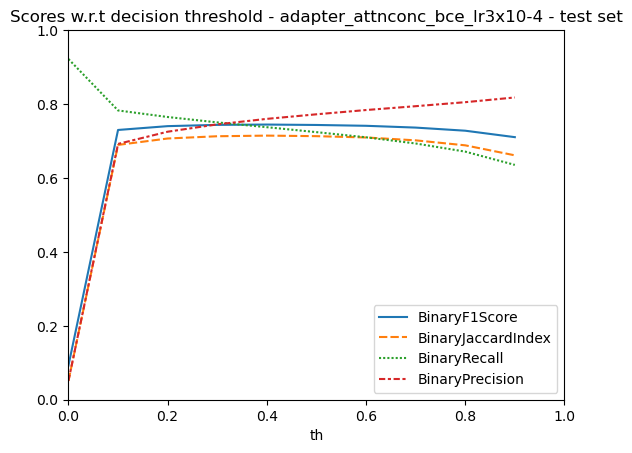

In [17]:
import seaborn as sns
sns.lineplot(scores)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.title(f"Scores w.r.t decision threshold - {exp_name} - {ds_type} set")

Text(0.5, 1.0, 'Scores w.r.t decision threshold - lora_concat - test set')

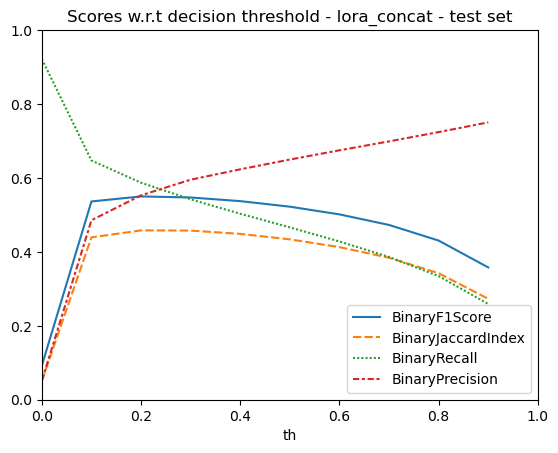

In [31]:
import seaborn as sns
sns.lineplot(scores)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.title(f"Scores w.r.t decision threshold - {exp_name} - {ds_type} set")

In [32]:
scores

,BinaryF1Score,BinaryJaccardIndex,BinaryRecall,BinaryPrecision
th,,,,
0.0,0.092513,0.050943,0.921875,0.050943
0.1,0.536455,0.439263,0.647242,0.485639
0.2,0.550009,0.458153,0.587128,0.552963
0.3,0.547200,0.457637,0.542211,0.595356
0.4,0.537310,0.448739,0.503135,0.623360
0.5,0.522283,0.433845,0.466304,0.649807
0.6,0.501471,0.412864,0.428111,0.674824
0.7,0.472861,0.384038,0.386238,0.698962
0.8,0.430607,0.342285,0.334479,0.724117


Text(0.5, 1.0, 'Scores w.r.t decision threshold - adapter_concat - test set')

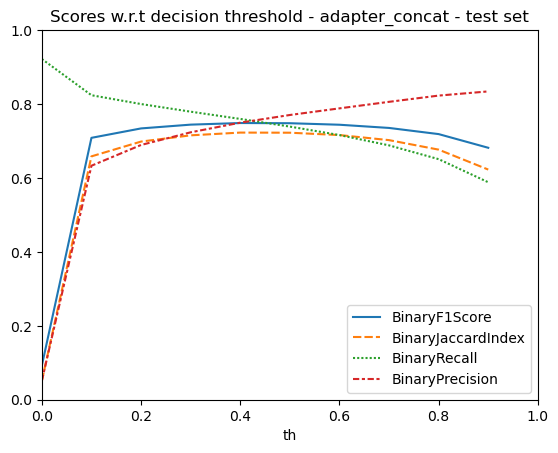

In [12]:
import seaborn as sns
sns.lineplot(scores)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.title(f"Scores w.r.t decision threshold - {exp_name} - {ds_type} set")

In [13]:
scores

,BinaryF1Score,BinaryJaccardIndex,BinaryRecall,BinaryPrecision
th,,,,
0.0,0.092513,0.050943,0.921875,0.050943
0.1,0.708568,0.658449,0.823860,0.633089
0.2,0.734045,0.698454,0.799966,0.689255
0.3,0.744273,0.715330,0.779357,0.723501
0.4,0.748629,0.722763,0.759728,0.749624
0.5,0.748098,0.722441,0.738983,0.770367
0.6,0.744012,0.716074,0.716072,0.788306
0.7,0.735345,0.702348,0.688180,0.805981
0.8,0.718673,0.676629,0.650869,0.822859


Text(0.5, 1.0, 'Scores w.r.t decision threshold - probing_concat_baseline - test set')

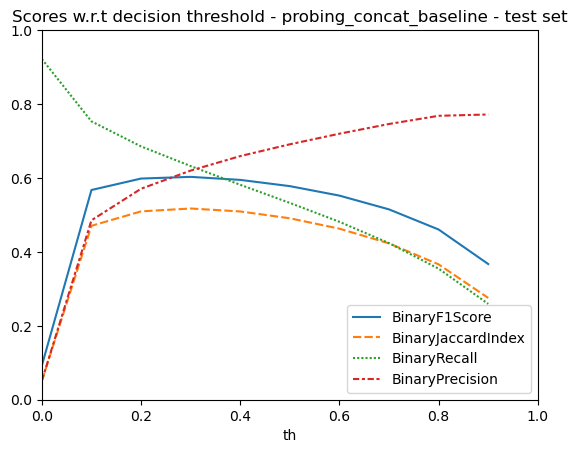

In [20]:
import seaborn as sns
sns.lineplot(scores)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.title(f"Scores w.r.t decision threshold - {exp_name} - {ds_type} set")

Text(0.5, 1.0, 'Scores based decision threshold - probing_concat_baseline')

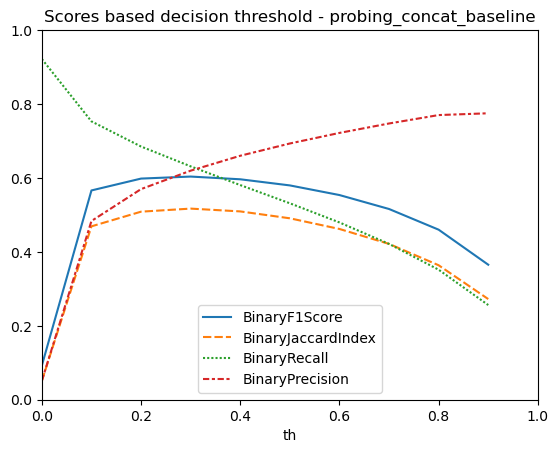

In [38]:
import seaborn as sns
sns.lineplot(scores)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.title(f"Scores w.r.t decision threshold - {exp_name} - {ds_type} set")

In [21]:
scores

,BinaryF1Score,BinaryJaccardIndex,BinaryRecall,BinaryPrecision
th,,,,
0.0,0.092513,0.050943,0.921875,0.050943
0.1,0.567399,0.470487,0.753143,0.485380
0.2,0.598393,0.509590,0.685396,0.570842
0.3,0.602961,0.517365,0.632196,0.619935
0.4,0.594774,0.509405,0.581527,0.659160
0.5,0.577878,0.490894,0.532516,0.691078
0.6,0.552220,0.462766,0.481348,0.719750
0.7,0.514960,0.422997,0.423583,0.746034
0.8,0.460479,0.366174,0.354578,0.768174


In [35]:
scores

,BinaryF1Score,BinaryJaccardIndex,BinaryRecall,BinaryPrecision
th,,,,
0.0,0.092513,0.050943,0.921875,0.050943
0.1,0.566229,0.469083,0.753108,0.483547
0.2,0.598322,0.508797,0.685064,0.569864
0.3,0.603792,0.517091,0.631404,0.619719
0.4,0.596410,0.509497,0.580730,0.660067
0.5,0.579846,0.490847,0.531492,0.693277
0.6,0.553774,0.461988,0.479626,0.721880
0.7,0.516029,0.421604,0.421558,0.747399
0.8,0.460049,0.363825,0.351758,0.770179


## Annexes

### Influence des values null : missing labels ?

In [46]:
df[(df.BinaryJaccardIndex > 0) & (~df.BinaryJaccardIndex.isna())].groupby("th")[metrics_col].mean()

,BinaryF1Score,BinaryJaccardIndex,BinaryRecall,BinaryPrecision
th,,,,
0.0,0.100353,0.055260,1.000000,0.055260
0.1,0.624804,0.477171,0.831016,0.533569
0.2,0.665959,0.522070,0.762506,0.634284
0.3,0.677942,0.535234,0.708945,0.695825
0.4,0.675580,0.532041,0.657818,0.747687
0.5,0.662681,0.517143,0.607419,0.792317
0.6,0.632884,0.486738,0.548144,0.825006
0.7,0.595061,0.448192,0.486121,0.861865
0.8,0.535330,0.390285,0.409318,0.896209


+0.1 en enlevant les nan et 0 :o

<Axes: >

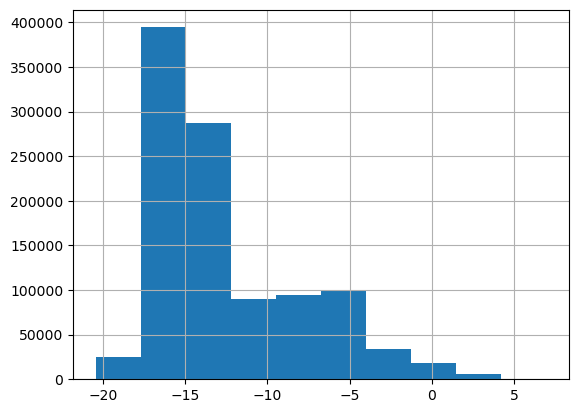

In [48]:
pd.Series(preds.flatten()).hist()

<Axes: >

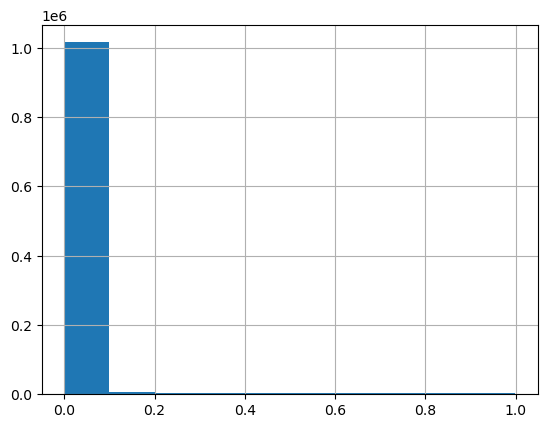

In [49]:
pd.Series(nn.Sigmoid()(preds.flatten())).hist()

<Axes: >

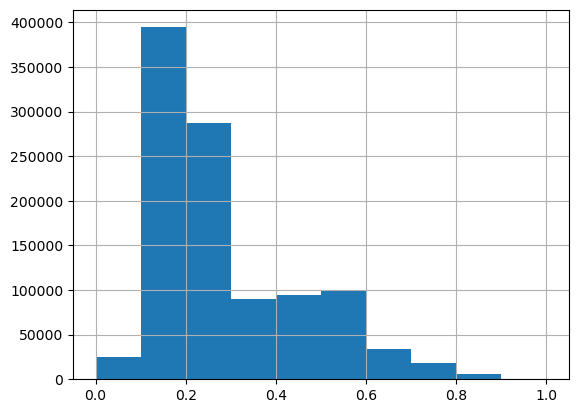

In [50]:
pd.Series(shift_range_values(preds.flatten())).hist()

In [ ]:
# NLP Example
batch, sentence_length, embedding_dim = 20, 5, 10
embedding = torch.randn(batch, sentence_length, embedding_dim)
layer_norm = nn.LayerNorm(embedding_dim)
# Activate module
layer_norm(embedding)


In [26]:
# Image Example
N, C, H, W = 20, 5, 10, 10
input = torch.zeros(N, C, H, W)
# Normalize over the last three dimensions (i.e. the channel and spatial dimensions)
# as shown in the image below
layer_norm = nn.LayerNorm([C, H, W])
output = layer_norm(input)

## Annexe

In [ ]:
from torchmetrics import MetricCollection
from torchmetrics.classification import BinaryF1Score, BinaryJaccardIndex, BinaryRecall, BinaryPrecision, Recall, Precision

exp_name = "_adapter_concat"
ds_name = "levir-cd"
device = "cuda"
batch_size = 1
ds_type = "test"
save_preds = False

report_dir = check_dir(PROJECT_PATH, "reports", "scores", ds_name, "instances", exp_name)

labels_track = []
df_all_th = []
th_list = np.arange(0., 1, 0.1)
scores = dict(zip(th_list, [[] for _ in range(len(th_list))]))

cfg, data_module, module = load_exp(exp_name)
ds = get_ds(ds_type, data_module)
dloader = data.DataLoader(ds, batch_size=batch_size, shuffle=False)

module = module.to(device)
sgmd = nn.Sigmoid()

@torch.no_grad()
def _step(module, batch, device):
    
    batch = convert_to_device(batch, device=device)
    preds, _ = module(batch)
    preds = preds.squeeze().detach()
    preds = sgmd(preds)
    label = batch["label"].squeeze().detach()
    return preds, label

def f1_score(precision, recall):
    if not (precision + recall):
        return 0
    return 2 * (precision*recall)/(precision + recall)
    
# micro metrics compute metrics on global counts TP, FP, etc - need to keep track them
eval_engine_micro = {
    th: MetricCollection(
            Recall(threshold=th, average="micro", task="binary"),
            Precision(threshold=th, average="micro", task="binary")
    ).to(device) for th in th_list
}
for i, batch in enumerate(tqdm(dloader)):
    
    preds, label = _step(module, batch, device)

    if save_preds:
        fname = f"pred_{Path(batch['label_path'].stem)}.pt"
        folder = check_dir(report_dir, f"pred_{ds_type}")
        torch.save(preds, make_path(fname, folder))
    
    for th in th_list:
    #     metrics = [
    #         BinaryF1Score(threshold=th),
    #         BinaryJaccardIndex(threshold=th),
    #         # define_micro average
    #         BinaryRecall(threshold=th),
    #         BinaryPrecision(threshold=th),
    #     ]
    #     eval_engine = MetricCollection(metrics).to(device)
    #     scores[th].append(eval_engine(preds, label))
        eval_engine_micro[th].update(preds, label)

    labels_track.append(next(iter(batch["label_path"])))
    
scores_micro = {th: eval_engine_micro[th].compute() for th in th_list}
df_micro = pd.DataFrame(scores_micro).map(float).T
df_micro["BinaryF1Score"] = df_micro.apply(lambda x: f1_score(x["BinaryPrecision"], x["BinaryRecall"]), axis=1)

# for th, res in scores.items():
#     df_score = pd.DataFrame(res).map(float)
#     df_score = df_score.assign(
#         label_path=labels_track,
#         th=th
#     )
#     df_all_th.append(df_score)
# df_all_th = pd.concat(df_all_th)
# df_all_th.to_csv(make_path(f"{exp_name}.csv", report_dir), index=True)
df_micro.columns = ["".join([_, "_micro"]) for _ in df_micro]
#adpater_concat_all_metrics = pd.concat([all_scores.loc["adapter_concat"], (df_micro.loc[th].round(3)*100)], axis=0)
df_all_th.to_csv(make_path(f"{exp_name}_scores_micro.csv", report_dir), index=True)

In [2]:
from torch import nn

In [3]:
layer = nn.Conv2d(3, 256, kernel_size=3)

In [4]:
img = torch.rand((3, 256, 256))

In [5]:
out = layer(img)

In [6]:
out.shape

torch.Size([256, 254, 254])

In [7]:
layer.weight.shape

torch.Size([256, 3, 3, 3])